# Hyperspectral image unmixing
We work on a hyperspectral satellite image. Each pixel has a reflectance spectrum which is a mix of several "pure material" spectral sources (or endmembers). The goal here is to estimate the relative proportion (or fractional abundance) of each endmember in a pixel. The language used is Julia. We will perform both a serial and a parallelized processing, first by using the JuliaOpt library, then by implementing manually algorithms such as the projected gradient or the linearly constrained Newton algorithm.

In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

In [2]:
size(img) # img is the image, of size 300x300 px, each pixel having a reflectance spectrum resampled to 255 points

(300, 300, 255)

In [3]:
size(sources) # the four spectral sources we use, each of them having a reflectance spectrum resampled to 255 points

(255, 4)

In [4]:
size(rgb) # rgb version of img

(300, 300, 3)

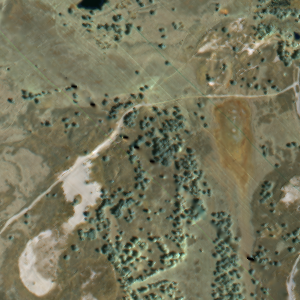

In [5]:
# visualize data in rgb (using bands 67,109,141 as the RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

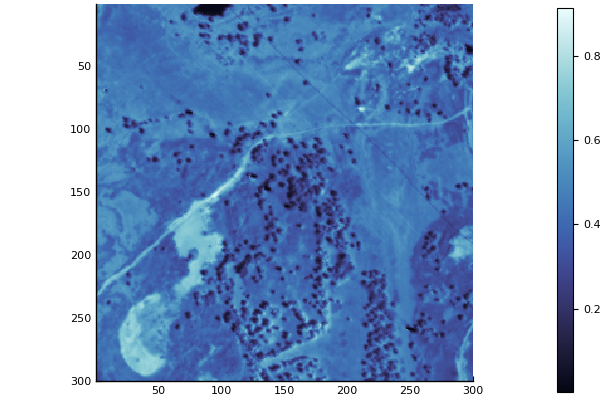

In [6]:
# visualize an arbitrary spectral band on its own
p2 = heatmap(img[:,:,141],aspect_ratio=1, yflip = true,c=:ice)

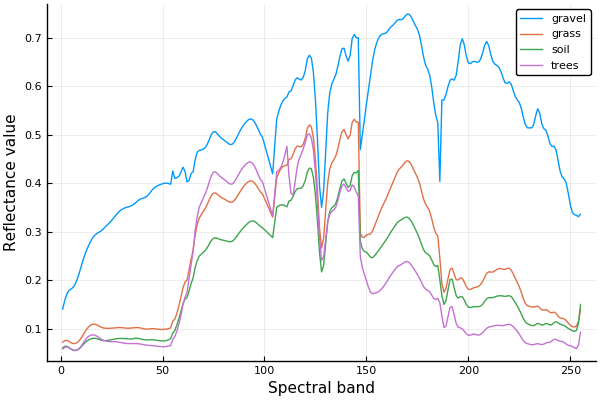

In [7]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is a Linear Mixing Model:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels.
 We have two constraints on the abundance matrix : all the coefficients must be positive, and the sum of the coefficients associated to eaxh pixel must be one. These constraints translate as the following : $\forall {i, j}$, $a_{i,j} > 0$ and $\mathbf{1}_P^T \mathbf{A} = \mathbf{1}_N$ (where $\mathbf{1}_{x}$ designates a vector of ones of size $x$).
 
 The hyperspectral image is represented as a $L \times N$, so the first thing to do is to reshape the 3D image to this matrix.

In order to estimate the abundance matrix, we use least squares. Thus, the optimization problem is the following :

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

## 1) Solving the problem using JuliaOpt

First, let us assess the performance of JuliaOpt on this problem :

In [2]:
using JuMP
using Ipopt

S = sources
L = 255 # spectrum size
N = 300*300 # number of pixels
P = 4; # number of endmembers

### Optimal solution for a single pixel

In [11]:
function opt_abundance_1px(px,verbose = true)
    m = Model(with_optimizer(Ipopt.Optimizer))
    @variable(m,a[1:P])
    @objective(m, Min, 1/2*(px - S*a)' * (px - S*a))  # least squares criterion
    for i=1:4
        @constraint(m, a[i] >= 0)  # positivity constraint
    end
    @constraint(m, sum(a)==1)  # being proportions, the abundance coefficients for the pixel must sum to one
 
    if verbose
       print(m)
    end

    set_silent(m)
    optimize!(m)
    if verbose
        println("\nObjective value: $(round(objective_value(m);digits=2))")
        println("a = $(round.(value.(a);digits=2))")
    end
    return value.(a)
end

# testing the function on an arbitrary pixel
px = img[10,134,:]
@time a = opt_abundance_1px(px)

Min 35.99489069165631 a[1]² + 37.763148022499976 a[2]*a[1] + 29.83280123046178 a[3]*a[1] + 28.509841580001332 a[4]*a[1] + 11.26823101695486 a[2]² + 17.842932334474696 a[3]*a[2] + 18.199111821809314 a[4]*a[2] + 7.081683688184231 a[3]² + 14.478444245662942 a[4]*a[3] + 7.919729988971243 a[4]² - 37.02991868768032 a[1] - 22.48588456152115 a[2] - 17.818630190391005 a[3] - 18.367583748220603 a[4] + 11.255342990505852
Subject to
 a[1] + a[2] + a[3] + a[4] == 1.0
 a[1] >= 0.0
 a[2] >= 0.0
 a[3] >= 0.0
 a[4] >= 0.0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be 

4-element Array{Float64,1}:
 1.160438528211549e-8 
 0.8892401739759583   
 2.3760316910819747e-8
 0.1107597906593396   

In hundredth of a second, function opt_abundance_1px finds the optimal coefficients associated to each endmember for one pixel. Below, let us print the spectrum of this pixel, as well as the weighted spectrum for each endmember. We see that this pixel is mostly grass.

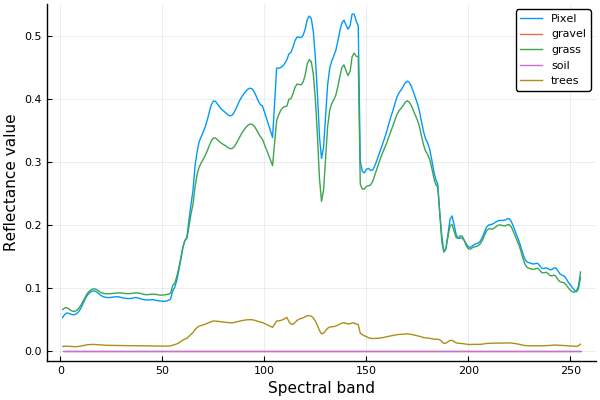

In [12]:
plot(px, label="Pixel")
plot!(a[1]*sources[:,1],label = "gravel")
plot!(a[2]*sources[:,2],label = "grass")
plot!(a[3]*sources[:,3],label = "soil")
plot!(a[4]*sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

Now, let us perform the optimisation on a whole pixel line of the image.

### Optimal solution for a line of pixels

In [13]:
function opt_abundance_line(l,verbose = true)
    # l is the line of pixels
    m = Model(with_optimizer(Ipopt.Optimizer))
    @variable(m,a[1:P,1:size(l)[1]])
    @objective(m, Min, 1/2* sum((l' - S*a)' * (l' - S*a)))
    @constraint(m, a .>= 0)
    for i=1:size(l)[1]
        @constraint(m, sum(a[:,i])==1)
    end
    set_silent(m)
    optimize!(m)
    if verbose
        println("\nObjective value: $(round(objective_value(m);digits=2))")
        println("A = $(round.(value.(a);digits=2))")
    end
    return value.(a)
end

# testing the function on a line of the cropped image
img_small = img[1:100,1:100,:];
line = img_small[1,:,:]
@time A = opt_abundance_line(line, false)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

4×100 Array{Float64,2}:
 -7.87063e-9  -7.87063e-9  -7.87063e-9  …  -7.87063e-9  -7.87063e-9
  1.11309e-8   1.11309e-8   1.11309e-8      1.11309e-8   1.11309e-8
  0.827392     0.827392     0.827392        0.827392     0.827392  
  0.172608     0.172608     0.172608        0.172608     0.172608  

When performing the optimization on a whole line of pixels, the complexity is much higher. We need around 9 seconds to fing the optimal abundance matrix. Let us now try and parallelize the process, then compare the performances.

### Parallelization

In the following, we will test our code on a small portion of the image. We will perform both parallelized and serial processing, and compare the performances of a pixel by pixel processing and a line by line processing.

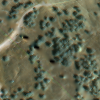

In [10]:
img_small = img[101:200,101:200,:];
p2 = colorview(RGB,permutedims(rgb[101:200,101:200,:],(3,1,2)))

In [11]:
using Distributed

CPU_CORES = 4
addprocs(CPU_CORES - 1) # 4 available processes
nworkers()

3

In [13]:
@everywhere using MAT
@everywhere using JuMP
@everywhere using Ipopt
@everywhere file = matopen("project_data.mat")
@everywhere img = read(file, "im")
@everywhere sources = read(file,"sources")
@everywhere close(file)
@everywhere S = sources
@everywhere P = 4

@everywhere function opt_abundance_line(l)
    m = Model(with_optimizer(Ipopt.Optimizer))
    @variable(m,a[1:P,1:size(l)[1]])
    @objective(m, Min, 1/2* sum((l' - S*a)' * (l' - S*a)))
    @constraint(m, a .>= 0)
    for i=1:size(l)[1]
        @constraint(m, sum(a[:,i])==1)
    end
    set_silent(m)
    optimize!(m)
    return value.(a)
end

In [52]:
t = @elapsed A = pmap(opt_abundance_line, [img_small[i,:,:] for i in range(1,stop=size(img_small)[1])])

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 4:	
      From worker 4:	Total number of variables............................:      400
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:      100
      From worker 4:	Total number of inequality constraints...............:      400
      

      From worker 2:	   5  3.2995764e+02 2.22e-16 2.00e-07  -1.7 8.52e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  2.0589411e+02 2.22e-16 2.83e-08  -2.5 6.04e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   7  1.6469207e+02 2.22e-16 1.50e-09  -3.8 2.82e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  1.5789368e+02 2.22e-16 1.84e-11  -5.7 4.92e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   9  1.5767031e+02 2.22e-16 1.84e-11  -5.7 1.49e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	  10  1.5765958e+02 2.22e-16 1.30e-13  -8.6 9.37e-06    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 10
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   5.5465913811035747e+00    1.5765957661874907e+02
  

      From worker 2:	   4  1.3783948e+03 2.22e-16 1.00e-06  -1.0 4.26e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   5  9.0850686e+02 2.22e-16 1.68e-01  -2.5 1.14e-01    -  8.93e-01 1.00e+00f  1
      From worker 2:	   6  7.9259717e+02 2.22e-16 2.83e-08  -2.5 5.14e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   7  7.6289769e+02 2.22e-16 1.50e-09  -3.8 2.64e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  7.6035382e+02 2.22e-16 1.50e-09  -3.8 1.11e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   9  7.5876878e+02 2.22e-16 1.84e-11  -5.7 6.32e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	  10  7.5854101e+02 2.22e-16 1.84e-11  -5.7 2.87e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

      From worker 4:	   5  8.5812945e+02 2.22e-16 1.75e-01  -2.5 1.15e-01    -  8.91e-01 1.00e+00f  1
      From worker 4:	   6  7.4100288e+02 2.22e-16 2.83e-08  -2.5 5.24e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  7.1135609e+02 2.22e-16 1.50e-09  -3.8 2.68e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  7.0929802e+02 2.22e-16 1.50e-09  -3.8 1.11e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  7.0801131e+02 2.22e-16 1.84e-11  -5.7 6.36e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	  10  7.0792481e+02 2.22e-16 1.84e-11  -5.7 2.90e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	  11  7.0791429e+02 2.22e-16 1.84e-11  -5.7 1.11e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	  12  7.0790376e+02 2.22e-16 2.31e-13  -8.6 3.24e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	  13  7.0790376e+02 2.22e-16 1.95e-13  -8.6 2.23e-05    -  1.

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 4:	
      From worker 4:	Total number of variables............................:      400
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:      100
      From worker 4:	Total number of inequality constraints...............:      400
      

      From worker 3:	   5  4.0857200e+01 2.22e-16 1.50e-09  -3.8 1.74e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  3.9815357e+01 2.22e-16 3.89e-04  -5.7 5.34e-03    -  9.84e-01 1.00e+00f  1
      From worker 3:	   7  3.9721075e+01 2.22e-16 1.84e-11  -5.7 5.34e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  3.9714414e+01 2.22e-16 3.60e-13  -8.6 3.55e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 8
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.2750436663738720e+00    3.9714413896173745e+01
      From worker 3:	Dual infeasibility......:   3.6037839379332581e-13    1.1224883561085636e-11
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 3:	Complementarity.........:   3.9465029576526160e-09    1.2292367393849877e-07
      From work

      From worker 2:	Objective...............:   1.4225910845265164e+00    4.4886655479171125e+01
      From worker 2:	Dual infeasibility......:   2.8405056085034630e-13    8.9625752630092303e-12
      From worker 2:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 2:	Complementarity.........:   9.0910928517738392e-10    2.8684894570567757e-08
      From worker 2:	Overall NLP error.......:   9.0910928517738392e-10    2.8684894570567757e-08
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9
      From worker 2:	Number of objective gradient evaluations             = 9
      From worker 2:	Number of equality constraint evaluations            = 9
      From worker 2:	Number of inequality constraint evaluations          = 9
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 

      From worker 3:	   3  6.9369619e+01 2.22e-16 8.31e-03  -2.5 1.59e-02    -  9.86e-01 1.00e+00f  1
      From worker 3:	   4  6.1392663e+01 2.22e-16 3.25e-04  -3.8 1.30e-02    -  9.98e-01 1.00e+00f  1
      From worker 3:	   5  5.8828531e+01 2.22e-16 1.84e-11  -5.7 6.34e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  5.8734256e+01 2.22e-16 1.84e-11  -5.7 2.36e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  5.8728393e+01 2.22e-16 1.85e-13  -8.6 1.28e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 7
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.8936646203736303e+00    5.8728393207163826e+01
      From worker 3:	Dual infeasibility......:   1.8499091147816671e-13    5.7371399730211153e-12
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From 

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   4  6.7917681e+01 2.22e-16 1.50e-09  -3.8 4.21e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  6.5212124e+01 2.22e-16 5.01e-05  -5.7 6.74e-03    -  9.97e-01 1.00e+00f  1
      From worker 4:	   6  6.5131359e+01 2.22e-16 1.84e-11  -5.7 2.08e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  6.5125301e+01 2.22e-16 7.62e-14  -8.6 1.50e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 7
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   2.0053102926198485e+00    6.5125301287228027e+01
      From worker 4:	Dual infeasibility......:   7.6161299489285739e-14    2.4734464256833211e-12
      From worker 4:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 4:	Complementarity.........:   2.6922874628486577e-09    8.7435861081018465e-08
      From work

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 4:	
      From worker 4:	Total number of variables............................:      400
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:      100
      From worker 4:	Total number of inequality constraints...............:      400
      

      From worker 2:	   3  5.3344007e+01 2.22e-16 1.18e-02  -2.5 1.69e-02    -  9.83e-01 1.00e+00f  1
      From worker 2:	   4  4.3792025e+01 2.22e-16 1.15e-02  -3.8 1.68e-02    -  9.47e-01 1.00e+00f  1
      From worker 2:	   5  4.0411513e+01 2.22e-16 1.50e-09  -3.8 1.22e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  3.9626159e+01 2.22e-16 1.64e-05  -5.7 2.70e-03    -  9.99e-01 1.00e+00f  1
      From worker 2:	   7  3.9592715e+01 2.22e-16 2.37e-13  -8.6 1.25e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  3.9592665e+01 2.22e-16 1.88e-13  -9.0 7.64e-07    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 8
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   1.2725703038790515e+00    3.9592665391561681e+01
      From worker 2:	Dual infeasibility......:   1.8819668046177185e-13    5.8552428691859293e-12
      F

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   4  3.8034778e+01 2.22e-16 1.50e-09  -3.8 4.91e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  3.4189925e+01 2.22e-16 1.50e-09  -3.8 1.63e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  3.3158314e+01 2.22e-16 6.26e-05  -5.7 5.02e-03    -  9.97e-01 1.00e+00f  1
      From worker 3:	   7  3.3085677e+01 2.22e-16 1.84e-11  -5.7 3.75e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  3.3079334e+01 2.22e-16 1.78e-13  -8.6 3.20e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 8
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.0270056081900412e+00    3.3079333794604111e+01
      From worker 3:	Dual infeasibility......:   1.7832957333041577e-13    5.7439058118118624e-12
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From 

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   1  2.6346255e+03 2.22e-16 1.75e+01  -1.0 2.85e-01    -  5.35e-02 1.00e+00f  1
      From worker 4:	   2  7.7085213e+01 2.22e-16 1.00e-06  -1.0 1.68e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  5.8809604e+01 2.22e-16 3.22e-02  -2.5 2.29e-02    -  9.52e-01 1.00e+00f  1
      From worker 4:	   4  4.1152486e+01 2.22e-16 2.83e-08  -2.5 5.37e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  3.3655212e+01 2.22e-16 2.38e-03  -3.8 2.75e-02    -  9.77e-01 1.00e+00f  1
      From worker 4:	   6  3.1792381e+01 2.22e-16 1.50e-09  -3.8 9.08e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  3.1134924e+01 2.22e-16 1.84e-11  -5.7 3.44e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  3.1095327e+01 2.22e-16 1.61e-13  -8.6 2.14e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  3.1095196e+01 2.22e-16 2.38e-13  -8.6 1.77e-06    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 9
      From 

      From worker 2:	   8  3.8095546e+01 2.22e-16 4.62e-13  -8.6 2.93e-05    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 8
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   1.1523275843202390e+00    3.8095545896160466e+01
      From worker 2:	Dual infeasibility......:   4.6163073363914009e-13    1.5261350192187025e-11
      From worker 2:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 2:	Complementarity.........:   3.2185205235116778e-09    1.0640315999508271e-07
      From worker 2:	Overall NLP error.......:   3.2185205235116778e-09    1.0640315999508271e-07
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9
      From worker 2:	Number of objective gradient evaluations             = 9
      From worker 2:	Nu

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   2  8.7750283e+01 2.22e-16 1.00e-06  -1.0 1.44e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  6.7054120e+01 2.22e-16 3.57e-02  -2.5 2.78e-02    -  9.43e-01 1.00e+00f  1
      From worker 3:	   4  4.7734121e+01 2.22e-16 2.83e-08  -2.5 5.32e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  3.9663632e+01 2.22e-16 9.99e-04  -3.8 2.49e-02    -  9.89e-01 1.00e+00f  1
      From worker 3:	   6  3.7686427e+01 2.22e-16 1.84e-11  -5.7 7.29e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  3.7554061e+01 2.22e-16 1.84e-11  -5.7 4.95e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  3.7547252e+01 2.22e-16 2.69e-13  -8.6 2.59e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 8
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.1345166133647133e+00    3.7547251610436341e+01
   

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   2  1.0566609e+02 2.22e-16 1.00e-06  -1.0 1.46e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  8.1686349e+01 2.22e-16 3.81e-02  -2.5 3.40e-02    -  9.34e-01 1.00e+00f  1
      From worker 4:	   4  6.0538615e+01 2.22e-16 2.83e-08  -2.5 5.35e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  5.2118837e+01 2.22e-16 8.24e-05  -3.8 2.28e-02    -  9.99e-01 1.00e+00f  1
      From worker 4:	   6  5.0511454e+01 2.22e-16 1.84e-11  -5.7 4.84e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  5.0454627e+01 2.22e-16 2.42e-13  -8.6 1.68e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  5.0454543e+01 2.22e-16 3.50e-13  -9.0 7.07e-07    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 8
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.5130316732319136e+00    5.0454543358735776e+01
   

      From worker 2:	   8  4.7439221e+01 2.22e-16 1.91e-13  -8.6 1.24e-06    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 8
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   1.4311494127712177e+00    4.7439220535224543e+01
      From worker 2:	Dual infeasibility......:   1.9142673557404066e-13    6.3453438503326493e-12
      From worker 2:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 2:	Complementarity.........:   2.5060155641652246e-09    8.3068493025433569e-08
      From worker 2:	Overall NLP error.......:   2.5060155641652246e-09    8.3068493025433569e-08
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9
      From worker 2:	Number of objective gradient evaluations             = 9
      From worker 2:	Nu

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   6  4.3309592e+01 2.22e-16 1.84e-11  -5.7 4.94e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  4.3249561e+01 2.22e-16 4.86e-13  -8.6 1.80e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  4.3249471e+01 2.22e-16 5.00e-13  -8.6 1.20e-06    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 8
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.3043206153442826e+00    4.3249471432747811e+01
      From worker 3:	Dual infeasibility......:   4.9954484993008919e-13    1.6564217771506210e-11
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 3:	Complementarity.........:   2.5059666812628809e-09    8.3094396513919132e-08
      From worker 3:	Overall NLP error.......:   2.5059666812628809e-09    8.3094396513919132e-08
      From worker 3

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   5  5.0644743e+01 2.22e-16 1.50e-09  -3.8 2.04e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  4.9175794e+01 2.22e-16 1.84e-11  -5.7 4.08e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  4.9134054e+01 2.22e-16 3.29e-13  -8.6 1.14e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  4.9134013e+01 2.22e-16 2.44e-13  -9.0 1.15e-06    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 8
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.4841304617322559e+00    4.9134013444136947e+01
      From worker 4:	Dual infeasibility......:   2.4353609406890797e-13    8.0625699887245020e-12
      From worker 4:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 4:	Complementarity.........:   9.0910123623965807e-10    3.0096944652254674e-08
      From work

      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 8
      From worker 2:	Number of objective gradient evaluations             = 8
      From worker 2:	Number of equality constraint evaluations            = 8
      From worker 2:	Number of inequality constraint evaluations          = 8
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 2:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.152
      From worker 2:	Total CPU secs in NLP function evaluations           =      0.001
      From worker 2:	
      From worker 2:	EXIT: Optimal Solution Found.
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see 

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   1  2.9230131e+03 2.22e-16 1.80e+01  -1.0 2.89e-01    -  5.22e-02 1.00e+00f  1
      From worker 3:	   2  1.0710162e+02 2.22e-16 1.00e-06  -1.0 1.46e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  8.7727194e+01 2.22e-16 2.60e-02  -2.5 2.41e-02    -  9.54e-01 1.00e+00f  1
      From worker 3:	   4  6.5988650e+01 2.22e-16 1.50e-09  -3.8 4.95e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  6.3464047e+01 2.22e-16 1.84e-11  -5.7 6.22e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  6.3402005e+01 2.22e-16 1.84e-11  -5.7 1.47e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  6.3395945e+01 2.22e-16 1.39e-13  -8.6 1.41e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 7
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.9427814561247816e+00    6.3395945163634956e+01
   

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   1  2.7246209e+03 2.22e-16 1.77e+01  -1.0 2.87e-01    -  5.30e-02 1.00e+00f  1
      From worker 4:	   2  1.1388201e+02 2.22e-16 1.00e-06  -1.0 1.47e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  8.9861227e+01 2.22e-16 3.43e-02  -2.5 3.31e-02    -  9.37e-01 1.00e+00f  1
      From worker 4:	   4  7.0410643e+01 2.22e-16 2.83e-08  -2.5 4.59e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  6.2329774e+01 2.22e-16 1.50e-09  -3.8 1.88e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  6.1092824e+01 2.22e-16 1.84e-11  -5.7 3.09e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  6.1068427e+01 2.22e-16 2.44e-13  -8.6 5.87e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 7
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.8427548767459214e+00    6.1068427091093781e+01
   

      From worker 2:	Complementarity.........:   9.4731739472655062e-09    3.1141352495210366e-07
      From worker 2:	Overall NLP error.......:   9.4731739472655062e-09    3.1141352495210366e-07
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 8
      From worker 2:	Number of objective gradient evaluations             = 8
      From worker 2:	Number of equality constraint evaluations            = 8
      From worker 2:	Number of inequality constraint evaluations          = 8
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 2:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.158
      From worker 2:	Total CPU secs in NLP function evaluations           =      0.001
      From worker 2:	
      From worker 

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   6  5.4516953e+01 2.22e-16 1.84e-11  -5.7 1.93e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  5.4510864e+01 2.22e-16 1.74e-13  -8.6 1.45e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 7
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.6745192247959411e+00    5.4510864000948921e+01
      From worker 3:	Dual infeasibility......:   1.7352785874891197e-13    5.6488772231268463e-12
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 3:	Complementarity.........:   2.6901661227285918e-09    8.7573362840243570e-08
      From worker 3:	Overall NLP error.......:   2.6901661227285918e-09    8.7573362840243570e-08
      From worker 3:	
      From worker 3:	
      From worker 3:	Number of objective function evaluations             = 8

      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 3:	
      From worker 3:	Total number of variables............................:      400
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:      100
      From worker 3:	Total number of inequality constraints...............:      400
      

      From worker 4:	   2  1.2629188e+02 2.22e-16 1.00e-06  -1.0 1.48e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  9.7554717e+01 2.22e-16 3.73e-02  -2.5 4.02e-02    -  9.27e-01 1.00e+00f  1
      From worker 4:	   4  7.5465113e+01 2.22e-16 2.83e-08  -2.5 4.95e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  6.7192768e+01 2.22e-16 1.50e-09  -3.8 1.94e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  6.6152081e+01 2.22e-16 1.84e-11  -5.7 2.63e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  6.6137543e+01 2.22e-16 1.90e-13  -8.6 3.58e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 7
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.9802042185121955e+00    6.6137543103650657e+01
      From worker 4:	Dual infeasibility......:   1.8969808363022977e-13    6.3357935840580478e-12
      F

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 4:	
      From worker 4:	Total number of variables............................:      400
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:      100
      From worker 4:	Total number of inequality constraints...............:      400
      

      From worker 2:	   2  1.3837463e+02 2.22e-16 1.00e-06  -1.0 1.46e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   3  1.0687809e+02 2.22e-16 4.11e-02  -2.5 4.31e-02    -  9.21e-01 1.00e+00f  1
      From worker 2:	   4  8.1872411e+01 2.22e-16 2.83e-08  -2.5 5.42e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   5  7.3078049e+01 2.22e-16 1.50e-09  -3.8 2.18e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  7.2069114e+01 2.22e-16 1.84e-11  -5.7 3.10e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   7  7.2059414e+01 2.22e-16 2.22e-13  -8.6 4.92e-05    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 7
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   2.1565638658737072e+00    7.2059414158398482e+01
      From worker 2:	Dual infeasibility......:   2.2174970193411525e-13    7.4095434241628907e-12
      F

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 2:	
      From worker 2:	Total number of variables............................:      400
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:      100
      From worker 2:	Total number of inequality constraints...............:      400
      

      From worker 3:	   2  9.6227039e+01 2.22e-16 1.00e-06  -1.0 1.40e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  6.9245449e+01 2.22e-16 5.04e-02  -2.5 4.08e-02    -  9.19e-01 1.00e+00f  1
      From worker 3:	   4  4.4044080e+01 2.22e-16 2.83e-08  -2.5 7.00e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  3.5284173e+01 2.22e-16 1.75e-03  -3.8 3.19e-02    -  9.82e-01 1.00e+00f  1
      From worker 3:	   6  3.3395299e+01 2.22e-16 1.50e-09  -3.8 8.20e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   7  3.2758899e+01 2.22e-16 1.84e-11  -5.7 2.94e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  3.2730679e+01 2.22e-16 2.01e-13  -8.6 1.30e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   9  3.2730627e+01 2.22e-16 1.61e-13  -9.0 1.09e-06    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)

      From worker 4:	   8  3.1037253e+01 2.22e-16 1.79e-13  -8.6 7.51e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 8
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   9.0890023685458432e-01    3.1037252943070175e+01
      From worker 4:	Dual infeasibility......:   1.7917611838669245e-13    6.1185312559391391e-12
      From worker 4:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 4:	Complementarity.........:   5.0732633957026633e-09    1.7324251097586066e-07
      From worker 4:	Overall NLP error.......:   5.0732633957026633e-09    1.7324251097586066e-07
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 9
      From worker 4:	Number of objective gradient evaluations             = 9
      From worker 4:	Nu

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:      400
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:      400
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:    80200
      From worker 4:	
      From worker 4:	Total number of variables............................:      400
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:      100
      From worker 4:	Total number of inequality constraints...............:      400
      

327.517816599

      From worker 4:	Number of Iterations....: 8
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.1041352332528496e+00    3.7575975760138384e+01
      From worker 4:	Dual infeasibility......:   7.8763384703250949e-14    2.6804787541075180e-12
      From worker 4:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 4:	Complementarity.........:   3.0328005034540542e-09    1.0321239171708220e-07
      From worker 4:	Overall NLP error.......:   3.0328005034540542e-09    1.0321239171708220e-07
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 9
      From worker 4:	Number of objective gradient evaluations             = 9
      From worker 4:	Number of equality constraint evaluations            = 9
      From worker 4:	Number of inequality constraint evaluations     

In [59]:
size(A[1])

(4, 100)

In [54]:
print("Time for parallelized treatment, line by line : ", t, "sec")

Time for parallelized treatment, line by line : 327.517816599sec

A parallelized line by line processing for an image of sixe 100x100 pixels takes around 330 seconds. Let us perform the operation using a serial processing, in order to compare execution times :

In [64]:
t = @elapsed A = map(opt_abundance_line, [img_small[i,:,:] for i in range(1,stop=size(img_small)[1])])

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04; 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.85 0.8

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22 0.22; 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.63 0.6

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27 0.27

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29; 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.51 0.5

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29 0.29

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.4

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53 0.53

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46 0.46; 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.31 0.3

A = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45 0.45; 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.33 0.3

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4; 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54 0.54

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

A = [-0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0; 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48 0.48

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      400
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:    80200

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:      400
        inequality constraints with only lower bounds:      400
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

880.095098901

In [65]:
print("Time for serial treatment, line by line : ", t, "sec")

Time for serial treatment, line by line : 880.095098901sec

A serial line by line processing of a 100x100 image takes around 880 seconds, which is much more than the parallelized processing.

In [14]:
@everywhere function opt_abundance_1px(px)
    m = Model(with_optimizer(Ipopt.Optimizer));
    @variable(m,a[1:P]);
    @objective(m, Min, 1/2*(px - S*a)' * (px - S*a));
    for i=1:4
        @constraint(m, a[i] >= 0);
    end
    @constraint(m, sum(a)==1);
 
    set_silent(m);
    optimize!(m);
    return value.(a)
end

In [108]:
vect = reshape(img_small,(1,10000,255))
t = @elapsed A = pmap(opt_abundance_1px, [vect[1,i,:] for i in range(1,stop=10000)])

      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      

      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   5.4622929847517702e-03    5.4622929847517702e-03
      From worker 4:	Dual infeasibility......:   9.0909090910998750e-15    9.0909090910998750e-15
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   9.1082498863005383e-10    9.1082498863005383e-10
      From worker 4:	Overall NLP error.......:   9.1082498863005383e-10    9.1082498863005383e-10
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 12
      From worker 4:	Number of objective gradient evaluations             = 12
      From worker 4:	Number of equality constraint evaluations            = 12
      From worker 4:	Number of inequality constraint evaluations          = 12
      From worker 4:	Number of equality constraint Jacobia

      From worker 3:	   0  9.7405565e+00 1.00e+00 6.37e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  2.7793655e-01 0.00e+00 1.52e+01  -1.0 2.62e-01    -  6.13e-02 1.00e+00f  1
      From worker 3:	   2  1.3213507e-02 0.00e+00 1.00e-06  -1.0 1.67e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  1.1683524e-02 0.00e+00 1.21e-02  -2.5 1.47e-02    -  9.76e-01 1.00e+00f  1
      From worker 3:	   4  8.1202394e-03 0.00e+00 1.50e-09  -3.8 1.16e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  7.6484960e-03 0.00e+00 1.50e-09  -3.8 4.09e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  7.6051571e-03 0.00e+00 1.88e-04  -5.7 1.40e-02    -  9.84e-01 1.00e+00f  1
      From worker 3:	   7  7.6045962e-03 0.00e+00 1.84e-11  -5.7 1.65e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  7.6045942e-03 0.00e+00 2.51e-14  -8.6 1.04e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 8
      From 

      From worker 4:	   4  1.7779031e-02 0.00e+00 1.50e-09  -3.8 1.44e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  1.6975959e-02 0.00e+00 1.50e-09  -3.8 5.49e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  1.6861053e-02 1.11e-16 2.27e-04  -5.7 2.03e-02    -  9.82e-01 1.00e+00f  1
      From worker 4:	   7  1.6854519e-02 0.00e+00 1.84e-11  -5.7 4.46e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  1.6854427e-02 2.22e-16 2.51e-14  -8.6 5.49e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  1.6854427e-02 0.00e+00 2.51e-14  -8.6 7.72e-06    -  1.00e+00 1.00e+00h  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 9
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.6854426856609837e-02    1.6854426856609837e-02
      From worker 4:	Dual infeasibility......:   2.5059035640133008e-14    2.5059035640133008e-14
      F

      From worker 3:	   8  1.5507819e-01 0.00e+00 1.84e-11  -5.7 7.75e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   9  1.5502166e-01 0.00e+00 1.84e-11  -5.7 8.11e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	  10  1.5501545e-01 0.00e+00 2.51e-14  -8.6 4.05e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 10
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.5501545179383452e-01    1.5501545179383452e-01
      From worker 3:	Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
      From worker 3:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 3:	Complementarity.........:   3.9107714816350115e-09    3.9107714816350115e-09
      From wor

      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  7.0012098e+00 1.00e+00 5.72e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  7.5582688e-01 2.22e-16 1.57e+01  -1.0 2.67e-01    -  5.93e-02 1.00e

      From worker 2:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 2:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 2:	Complementarity.........:   4.8411728977112291e-09    4.8411728977112291e-09
      From worker 2:	Overall NLP error.......:   4.8411728977112291e-09    4.8411728977112291e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9
      From worker 2:	Number of objective gradient evaluations             = 9
      From worker 2:	Number of equality constraint evaluations            = 9
      From worker 2:	Number of inequality constraint evaluations          = 9
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 

      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  7.5159111e+00 1.00e+00 5.78e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  6.4201749e-01 1.11e-16 1.56e+01  -1.0 2.66e-01    -  5.96e-02 1.00e+00f  1
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros 

      From worker 4:	   3  1.6789592e-01 0.00e+00 1.00e-06  -1.0 9.10e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   4  1.0596846e-01 0.00e+00 1.50e-01  -2.5 1.64e-01    -  7.85e-01 1.00e+00f  1
      From worker 4:	   5  7.1056622e-02 0.00e+00 2.83e-08  -2.5 1.30e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  5.8140649e-02 0.00e+00 9.33e-04  -3.8 6.14e-02    -  9.74e-01 1.00e+00f  1
      From worker 4:	   7  5.5850124e-02 0.00e+00 1.84e-11  -5.7 1.24e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  5.5772411e-02 0.00e+00 1.84e-11  -5.7 4.49e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  5.5768638e-02 0.00e+00 2.51e-14  -8.6 2.01e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 9
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   5.5768638061302105e-02    5.5768638061302105e-02
   

      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  6.0813673e+00 1.00e+00 5.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  1.0748053e+00 0.00e+00 1.61e+01  -1.0 2.71e-01    -  5.80e-02 1.00e+00f  1
      From worker 4:	   2  1.2891420e-01 0.00e+00 4.12e+00  -1.0 8.98e-01    -  1.00e+00 7.49e-01f  1
      From worker 4:	   3  2.4973538e-01 0.00e+00 1.00e-06  -1.0 4.22e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   4  1.4949501e-01 0.00e+00 2.46e-01  -2.5 1.81e-01    -  7.52e-01 1.00e+00f  1
      From worker 4:	   5  8.4135496e-02 0.00e+00 2.83e-08  -2.5 1.84e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  5.9692496e-02 1.11e-16 1.06e-02  -3.8 8.83e-02    -  9.47e-01 1.00e

      From worker 3:	Number of inequality constraint evaluations          = 11
      From worker 3:	Number of equality constraint Jacobian evaluations   = 1
      From worker 3:	Number of inequality constraint Jacobian evaluations = 1
      From worker 3:	Number of Lagrangian Hessian evaluations             = 1
      From worker 3:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.009
      From worker 3:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 3:	
      From worker 3:	EXIT: Optimal Solution Found.
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian..

      From worker 3:	   4  1.0084966e-01 0.00e+00 1.53e-01  -2.5 1.66e-01    -  7.85e-01 1.00e+00f  1
      From worker 3:	   5  6.6765480e-02 0.00e+00 2.83e-08  -2.5 1.30e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  5.4193553e-02 0.00e+00 1.26e-03  -3.8 6.38e-02    -  9.71e-01 1.00e+00f  1
      From worker 3:	   7  5.2017321e-02 0.00e+00 1.50e-09  -3.8 1.31e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  5.1642989e-02 0.00e+00 1.84e-11  -5.7 2.23e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   9  5.1636347e-02 0.00e+00 2.51e-14  -8.6 4.04e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   5.1636347317577179e-02    5.1636347317577179e-02
      From worker 3:	Dual infeasibility......:   2.5059036063649481e-14    2.5059036063649481e-14
      F

      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
    

      From worker 2:	   7  2.7392754e-02 0.00e+00 1.50e-09  -3.8 2.84e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  2.6606114e-02 0.00e+00 8.13e-06  -5.7 6.17e-03    -  9.98e-01 1.00e+00f  1
      From worker 2:	   9  2.6582612e-02 0.00e+00 2.51e-14  -8.6 1.87e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	  10  2.6582592e-02 1.11e-16 9.10e-15  -9.0 1.65e-07    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 10
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   2.6582591980717822e-02    2.6582591980717822e-02
      From worker 2:	Dual infeasibility......:   9.1038288019262836e-15    9.1038288019262836e-15
      From worker 2:	Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
      From

      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
    

      From worker 2:	Number of equality constraint evaluations            = 10
      From worker 2:	Number of inequality constraint evaluations          = 10
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 2:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
      From worker 2:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 2:	
      From worker 2:	EXIT: Optimal Solution Found.
      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jaco

      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
    

      From worker 4:	
      From worker 4:	EXIT: Optimal Solution Found.
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 

      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   1.8629577100336875e-01    1.8629577100336875e-01
      From worker 4:	Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   3.1416781039447111e-09    3.1416781039447111e-09
      From worker 4:	Overall NLP error.......:   3.1416781039447111e-09    3.1416781039447111e-09
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 12
      From worker 4:	Number of objective gradient evaluations             = 9
      From worker 4:	Number of equality constraint evaluations            = 12
      From worker 4:	Number of inequality constraint evaluations          = 12
      From worker 4:	Number of equali

      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  7.0942406e+00 1.00e+00 5.56e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  8.3174418e-01 0.00e+00 1.58e+01  -1.0 2.68e-01    -  5.89e-02 1.00e+00f  1
      From worker 4:	   2  1.9382373e-01 0.00e+00 6.73e+00  -1.0 8.41e-01    -  1.00e+00 5.83e-01f  1
      From worker 4:	   3  1.8717762e-01 0.00e+00 1.00e-06  

      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number of variables............................:        4
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	

      From worker 3:	   9  1.0247209e-01 2.22e-16 2.51e-14  -8.6 1.77e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.0247208761312061e-01    1.0247208761312061e-01
      From worker 3:	Dual infeasibility......:   2.5059036063649481e-14    2.5059036063649481e-14
      From worker 3:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 3:	Complementarity.........:   2.6709188569530153e-09    2.6709188569530153e-09
      From worker 3:	Overall NLP error.......:   2.6709188569530153e-09    2.6709188569530153e-09
      From worker 3:	
      From worker 3:	
      From worker 3:	Number of objective function evaluations             = 15
      From worker 3:	Number of objective gradient evaluations             = 10
      From worker 3:	

      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  7.8439815e+00 1.00e+00 5.99e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  6.4818154e-01 0.00e+00 1.55e+01  -1.0 2.65e-01    -  5.99e-02 1.00e+00f  1
      From worker 3:	   2  1.7727784e-01 2.22e-16 7.24e+00  -1.0 8.11e-01    -  1.00e+00 5.44e-01f  1
      From worker 3:	   3  1.8504849e-01 0.00e+00 1.00e-06  -1.0 2.26e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  1.1485150e-01 1.11e-16 1.79e-01  -2.5 1.63e-01    -  7.71e-01 1.00e+00f  1
      From worker 3:	   5  7.0023800e-02 0.00e+00 2.83e-08  -2.5 1.55e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  5.5759107e-02 0.00e+00 4.47e-03  -3.8 7.68e-02    -  9.55e-01 1.00e

      From worker 3:	   9  1.6700240e-01 0.00e+00 2.51e-14  -8.6 1.80e-05    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   1.6700239930559738e-01    1.6700239930559738e-01
      From worker 3:	Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
      From worker 3:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 3:	Complementarity.........:   2.6907486591174846e-09    2.6907486591174846e-09
      From worker 3:	Overall NLP error.......:   2.6907486591174846e-09    2.6907486591174846e-09
      From worker 3:	
      From worker 3:	
      From worker 3:	Number of objective function evaluations             = 13
      From worker 3:	Number of objective gradient evaluations             = 10
      From worker 3:	

      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  2.0966946e+01 1.00e+00 1.08e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  8.6976582e-01 0.00e+00 1.88e+01  -1.0 2.98e-01    -  5.01e-02 1.00e+00f  1
      From worker 3:	   2  5.2984739e-02 0.00e+00 1.00e-06  -1.0 2.30e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  4.8668113e-02 2.22e-16 3.46e-02  -2.5 2.24e-02    -  9.32e-01 1.00e+00f  1
      From worker 3:	   4  3.6276991e-02 2.

      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number of variables............................:        4
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality con

      From worker 2:	EXIT: Optimal Solution Found.
      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of ine

      From worker 2:	Objective...............:   1.0104760586029400e-01    1.0104760586029400e-01
      From worker 2:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   3.4677733959516178e-09    3.4677733959516178e-09
      From worker 2:	Overall NLP error.......:   3.4677733959516178e-09    3.4677733959516178e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 11
      From worker 2:	Number of objective gradient evaluations             = 10
      From worker 2:	Number of equality constraint evaluations            = 11
      From worker 2:	Number of inequality constraint evaluations          = 11
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluation

      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  8.0895751e+00 1.00e+00 6.19e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  6.9715120e-01 0.00e+00 1.55e+01  -1.0 2.65e-01    -  6.01e-02 1.00e+00f  1
      From worker 2:	   2  4.6729926e-01 1.11e-16 1.24e+01  -1.0 9.12e-01    -  1.00e+00 2.14e-01f  2
      From worker 2:	   3  2.4323157e-01 0.00e+00 1.00e-06  -1.0 1.07e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   4  1.6796411e-01 0.00e+00 1.51e-01  -2.5 1.72e-01    -  7.88e-01 1.00e+00f  1
      From worker 2:	   5 

      From worker 2:	   7  7.6258057e-02 0.00e+00 1.84e-11  -5.7 1.98e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  7.6252727e-02 0.00e+00 2.51e-14  -8.6 3.55e-05    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 8
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   7.6252726805145429e-02    7.6252726805145429e-02
      From worker 2:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   2.7079662450934133e-09    2.7079662450934133e-09
      From worker 2:	Overall NLP error.......:   2.7079662450934133e-09    2.7079662450934133e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9

      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  1.5554935e+01 1.00e+00 9.70e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  6.7399231e-01 0.00e+00 1.69e+01  -1.0 2.79e-01    -  5.52e-02 1.00e+00f  1
      From worker 2:	   2  4.0366733e-01 0.00e+00 9.06e+00  -1.0 2.53e-01    -  1.00e+00 4.75e-01f  2
      From worker 2:	   3  3.2550269e-01 0.00e+00 1.00e-06  -1.0 6.14e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   4  2.8801504e-01 0.00e+00 9.46e-02  -2.5 8.42e-02    -  7.98e-01 1.00e+00f  1
      From worker 2:	   5  2.4673065e-01 0.00e+00 2.83e-08  -2.5 1.23e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  2.3563121e-01 0.00e+00 1.31e-03  -3.8 4.04e-02    -  9.64e-01 1.00e

      From worker 2:	   7  4.1746716e-03 2.22e-16 1.84e-11  -5.7 3.79e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  4.1746473e-03 1.11e-16 2.38e-07  -8.6 3.90e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	   9  4.1746473e-03 1.11e-16 2.51e-14  -8.6 3.29e-06    -  1.00e+00 1.00e+00h  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 9
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   4.1746472654241307e-03    4.1746472654241307e-03
      From worker 2:	Dual infeasibility......:   2.5059035597119616e-14    2.5059035597119616e-14
      From worker 2:	Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
      From worker 2:	Complementarity.........:   2.5092646351598404e-09    2.5092646351598404e-09
      From worker 2:	Overall NLP error.......:   2.5092646351598404e-09    2.5092646351598404e-09
      From worker 2

      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  5.2436885e+00 1.00e+00 4.59e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  1.4465549e+00 0.00e+00 1.64e+01  -1.0 2.74e-01    -  5.68e-02 1.00e+00f  1
      From worker 2:	   2  2.4013175e-01 0.00e+00 5.47e+00  -1.0 9.82e-01    

      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   4.1549616678935752e-02    4.1549616678935752e-02
      From worker 2:	Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   2.5059868394952403e-09    2.5059868394952403e-09
      From worker 2:	Overall NLP error.......:   2.5059868394952403e-09    2.5059868394952403e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 11
      From worker 2:	Number of objective gradient evaluations             = 11
      From worker 2:	Number of equality constraint evaluations            = 11
      From worker 2:	Number of inequality constraint evaluations          = 11
      From worker 2:	Number of equal

      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   4.8869655757287529e-02    4.8869655757287529e-02
      From worker 4:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 4:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 4:	Complementarity.........:   2.7097082431890416e-09    2.7097082431890416e-09
      From worker 4:	Overall NLP error.......:   2.7097082431890416e-09    2.7097082431890416e-09
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 11
      From worker 4:	Number of objective gradient evaluations             = 10
      From worker 4:	Number of equality constraint evaluations            = 11
      From worker 4:	Number of inequality constraint evaluations          = 11
      From worker 4:	Number of equality constraint Jacobia

      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  3.7932201e+01 1.00e+00 1.51e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  5.3173964e+00 0.00e+00 2.60e+01  -1.0 3.70e-01    -  3.66e-02 1.00e+00f  1
      From worker 4:	   2  5.0306035e-01 0.00e+00 5.74e+00  -1.0 6.19e-01    -  1.00e+00 7.81e-01f  1
      From worker 4:	   3  3.5223400e-01 0.00e+00 1.58e+00  -1.0 1.29e-01    -  1.00e+00 7.16e-01f  1
      From worker 4:	   4  3.4902023e-01 2.22e-16 1.00e-06  -1.0 4.08e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  2.3311376e-01 1.11e-16 4.71e-02  -2.5 5.13e-02    -  9.69e-01 1.00e+00f  1
      From worker 4:	   6  2.0087888e-01 2.22e-16 2.83e-08  -2.5 2.48e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  1.8887836e-01 2.22e-16 1.50e-09  -3.8 1.49e-02    

      From worker 4:	   2  3.9702020e-01 0.00e+00 1.24e+01  -1.0 8.44e-01    -  1.00e+00 1.84e-01f  2
      From worker 4:	   3  3.3510139e-01 0.00e+00 1.00e-06  -1.0 7.89e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   4  2.7348737e-01 0.00e+00 1.03e-01  -2.5 1.38e-01    -  7.99e-01 1.00e+00f  1
      From worker 4:	   5  2.4105339e-01 0.00e+00 2.83e-08  -2.5 1.13e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  2.3048144e-01 2.22e-16 6.79e-04  -3.8 5.34e-02    -  9.75e-01 1.00e+00f  1
      From worker 4:	   7  2.2874592e-01 1.11e-16 1.84e-11  -5.7 1.30e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  2.2867674e-01 0.00e+00 1.84e-11  -5.7 6.32e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  2.2867292e-01 2.22e-16 2.51e-14  -8.6 1.97e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 9
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)

      From worker 4:	Number of equality constraint evaluations            = 12
      From worker 4:	Number of inequality constraint evaluations          = 12
      From worker 4:	Number of equality constraint Jacobian evaluations   = 1
      From worker 4:	Number of inequality constraint Jacobian evaluations = 1
      From worker 4:	Number of Lagrangian Hessian evaluations             = 1
      From worker 4:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.005
      From worker 4:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 4:	
      From worker 4:	EXIT: Optimal Solution Found.
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 4:	Number of nonzeros in inequality constraint Jaco

      From worker 4:	   7  6.2280323e-02 0.00e+00 1.50e-09  -3.8 2.64e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  6.1358110e-02 0.00e+00 1.84e-11  -5.7 6.84e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  6.1319753e-02 0.00e+00 1.84e-11  -5.7 4.46e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	  10  6.1314021e-02 0.00e+00 2.51e-14  -8.6 3.12e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 10
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   6.1314021035642374e-02    6.1314021035642374e-02
      From worker 4:	Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From

      From worker 4:	EXIT: Optimal Solution Found.
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 4:	
      From worker 4:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of ine

      From worker 4:	Objective...............:   1.8310365623480828e-02    1.8310365623480828e-02
      From worker 4:	Dual infeasibility......:   9.1038288019262836e-15    9.1038288019262836e-15
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   9.0926989649494610e-10    9.0926989649494610e-10
      From worker 4:	Overall NLP error.......:   9.0926989649494610e-10    9.0926989649494610e-10
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 13
      From worker 4:	Number of objective gradient evaluations             = 12
      From worker 4:	Number of equality constraint evaluations            = 13
      From worker 4:	Number of inequality constraint evaluations          = 13
      From worker 4:	Number of equality constraint Jacobian evaluations   = 1
      From worker 4:	Number of inequality constraint Jacobian evaluation

      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  5.1129335e+00 1.00e+00 4.62e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  1.5047201e+00 0.00e+00 1.65e+01  -1.0 2.75e-01    -  5.67e-02 1.00e+00f  1
      From worker 4:	   2  3.0310241e-01 2.22e-16 6.17e+00  -1.0 1.06e+00    -  1.00e+00 6.33e-01f  1
      From worker 4:	   3  3.9326421e-01 0.00e+00 1.00e-06  

      From worker 3:	   0  9.6519937e+00 1.00e+00 6.47e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  2.8143076e-01 0.00e+00 1.50e+01  -1.0 2.60e-01    -  6.17e-02 1.00e+00f  1
      From worker 3:	   2  8.8731380e-02 0.00e+00 7.70e+00  -1.0 3.15e-01    -  1.00e+00 5.00e-01f  2
      From worker 3:	   3  4.5451604e-02 1.11e-16 1.00e-06  -1.0 9.58e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  2.8919106e-02 0.00e+00 8.28e-02  -2.5 6.47e-02    -  8.75e-01 1.00e+00f  1
      From worker 3:	   5  1.5377884e-02 0.00e+00 2.83e-08  -2.5 9.13e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  9.5996978e-03 0.00e+00 6.52e-03  -3.8 8.25e-02    -  8.88e-01 1.00e+00f  1
      From worker 3:	   7  8.1480868e-03 0.00e+00 1.50e-09  -3.8 2.95e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  7.7626418e-03 0.00e+00 4.88e-05  -5.7 8.47e-03    -  9.92e-01 1.00e+00f  1
      From worker 3:	   9  7.7410174e-03 2.22e-16 1.84e-11  -5.7 4.96e-04    -  1.

      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  9.3761140e+00 1.00e+00 6.21e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  3.3309278e-01 0.00e+00 1.53e+01  -1.0 2.63e-01    -  6.08e-02 1.00e+00f  1
      From worker 3:	   2  1.3728354e-02 2.22e-16 1.00e-06  -1.0 2.13e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  1.2094960e-02 2.22e-16 7.47e-03  -2.5 1.10e-02    -  9.86e-01 1.00e+00f  1
      From worker 3:	   4  8.6792044e-03 0.00e+00 1.50e-09  -3.8 1.04e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5 

      From worker 3:	Dual infeasibility......:   2.5313084961453569e-14    2.5313084961453569e-14
      From worker 3:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 3:	Complementarity.........:   2.5090060889271364e-09    2.5090060889271364e-09
      From worker 3:	Overall NLP error.......:   2.5090060889271364e-09    2.5090060889271364e-09
      From worker 3:	
      From worker 3:	
      From worker 3:	Number of objective function evaluations             = 12
      From worker 3:	Number of objective gradient evaluations             = 12
      From worker 3:	Number of equality constraint evaluations            = 12
      From worker 3:	Number of inequality constraint evaluations          = 12
      From worker 3:	Number of equality constraint Jacobian evaluations   = 1
      From worker 3:	Number of inequality constraint Jacobian evaluations = 1
      From worker 3:	Number of Lagrangian Hessian evaluations             = 1
      From wor

Excessive output truncated after 524297 bytes.


      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  7.0202616e+00 1.00e+00 5.53e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  7.5761845e-01 0.00e+00 1.58e+01  -1.0 2.68e-01    -  5.91e-02 1.00e+00f  1
      From worker 3:	   2  1.0275932e-01 0.00e+00 4.30e+00  -1.0 6.95e-01    -  1.00e+00 7.34e-01f  1
      From worker 3:	   3  1.2714238e-01 2.22e-16 1.00e-06  -1.0 2.55e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  7.7136558e-02 0.00e+00 1.77e-01  -2.5 1.38e-01    -  8.02e-01 1.00e+00f  1
      From worker 3:	   5  4.4316175e-02 0.00e+00 2.83e-08  -2.5 1.63e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  3.3203141e-02 0.00e+00 1.41e-02  -3.8 9.32e-02    -  9.35e-01 1.00e+00f  1
      From worker 3:	   7  3.0153879e-02 0.00e+00 1.50e-09  -3.8 4.04e-02   

150.432900401

In [109]:
print("Time for parallelized treatment, pixel by pixel : ", t, "sec")

Time for parallelized treatment, pixel by pixel : 150.432900401sec

A parallelized pixel by pixel processing of a 100x100 image takes around 140 seconds. Let us compare it with a serial processing :

In [104]:
vect = reshape(img_small,(1,10000,255))
t = @elapsed A = map(opt_abundance_1px, [vect[1,i,:] for i in range(1,stop=10000)]);

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

Objective value: 0.01
a = [0.02, 0.37, 0.61, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.02
a = [0.03, 0.7, 0.24, 0.03]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.0
a = [0.0, 0.27, 0.71, 0.01]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 


Objective value: 0.01
a = [0.01, 0.0, 0.73, 0.27]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

Objective value: 1.36
a = [-0.0, -0.0, 0.95, 0.05]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

Objective value: 0.04
a = [0.02, -0.0, 0.98, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

Objective value: 0.03
a = [0.03, 0.0, 0.97, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.05
a = [-0.0, 0.0, 1.0, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du l


Objective value: 0.03
a = [0.03, -0.0, 0.97, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_


Objective value: 0.06
a = [0.29, 0.34, 0.37, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

Objective value: 1.34
a = [1.0, -0.0, -0.0, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du


Objective value: 0.14
a = [0.19, 0.0, 0.81, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

Objective value: 0.11
a = [-0.0, -0.0, 1.0, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du


Objective value: 0.08
a = [0.1, 0.0, 0.9, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.2
a = [0.09, 0.0, 0.91, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.05
a = [0.06, 0.0, 0.94, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.12
a = [0.04, 0.0, 0.96, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.12
a = [0.11, 0.0, 0.89, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

a = [0.5, 0.5, -0.0, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) a

Objective value: 0.05
a = [0.3, 0.0, 0.58, 0.11]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 


Objective value: 0.04
a = [0.75, 0.0, 0.25, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.23
a = [0.19, 0.0, 0.81, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.02
a = [0.01, 0.0, 0.91, 0.09]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.01
a = [0.02, 0.48, 0.43, 0.07]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d


Objective value: 0.01
a = [0.0, 0.0, 1.0, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du l

Objective value: 0.02
a = [-0.0, 0.0, 0.86, 0.14]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.05
a = [-0.0, 0.0, 0.27, 0.73]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.03
a = [0.1, 0.0, 0.9, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du l

Objective value: 0.05
a = [0.07, 0.0, 0.93, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.16
a = [-0.0, -0.0, 0.9, 0.1]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.11
a = [-0.0, -0.0, 0.99, 0.01]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_d

a = [0.25, 0.23, 0.52, 0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg)

a = [1.0, -0.0, -0.0, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg)


Objective value: 0.12
a = [0.26, 0.06, 0.68, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_

Objective value: 0.17
a = [-0.0, -0.0, 1.0, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

Objective value: 0.05
a = [0.05, 0.0, 0.95, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du

a = [0.06, 0.0, 0.94, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg)


Objective value: 0.18
a = [0.1, 0.0, 0.9, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du 

Objective value: 0.04
a = [0.0, 0.0, 1.0, -0.0]
This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du l

Excessive output truncated after 525443 bytes.

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        4
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        4
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [106]:
print("Time for serial treatment, pixel by pixel : ", t, "sec")

Time for serial treatment, pixel by pixel : 103.9540352sec

The execution time for a serial, pixel by pixel processing of a 100x100 px image is about 105 seconds. A serial processing is thus faster when the problem is divided in a lot of small tasks.

In [99]:
size(A[1])

(4,)

In [103]:
A_ = hcat(A...)
A_reshaped = reshape(A_,(4,100,100));

To vizualize the result of the optimization we performed, let us use a specific colour for each endmember, then build again the image assigning to each pixel the colour of its majority endmember :

In [101]:
M=[[0 for i in 1:100] for j in 1:100]
grass = RGB{Float32}(0.3,0.6,0.1)
trees = RGB{Float32}(0.3,0.4,0.3)
soil =  RGB{Float32}(0.5,0.3,0.1)
gravel = RGB{Float32}(0.5,0.5,0.5)
colors = [gravel grass soil trees]
for i in 1:100
    for j in 1:100
        M[i][j]=findmax(A_reshaped[:,i,j])[2]
    end
end
Map=rand(colors, 100, 100)
for i in 1:100
    for j in 1:100
        Map[i,j]=colors[M[i][j]]
    end
end

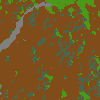

In [102]:
Map


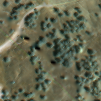

In [93]:
p2 = colorview(RGB,permutedims(rgb[100:200,100:200,:],(3,1,2)))

### Parallelized and Serial pixel by pixel processing of the whole image

In [15]:
N = 300*300
vect = reshape(img,(1,N,255))
t = @elapsed A = pmap(opt_abundance_1px, [vect[1,i,:] for i in range(1,stop=N)])

      From worker 3:	
      From worker 3:	******************************************************************************
      From worker 3:	This program contains Ipopt, a library for large-scale nonlinear optimization.
      From worker 3:	 Ipopt is released as open source code under the Eclipse Public License (EPL).
      From worker 3:	         For more information visit http://projects.coin-or.org/Ipopt
      From worker 3:	******************************************************************************
      From worker 3:	
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
   

      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   1.4041839872911999e-01    1.4041839872911999e-01
      From worker 2:	Dual infeasibility......:   9.0909091142609322e-15    9.0909091142609322e-15
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   9.0914912822915899e-10    9.0914912822915899e-10
      From worker 2:	Overall NLP error.......:   9.0914912822915899e-10    9.0914912822915899e-10
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 14
      From worker 2:	Number of objective gradient evaluations             = 11
      From worker 2:	Number of equality constraint evaluations            = 14
      From worker 2:	Number of inequality constraint evaluations          = 14
      From worker 2:	Number of equality constraint Jacobia

      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  5.9314771e+00 1.00e+00 4.57e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  1.2531049e+00 2.22e-16 1.65e+01  -1.0 2.75e-01    -  5.65e-02 1.00e+00f  1
      From worker 3:	   2  1.0494998e-01 0.00e+00 3.27e+00  -1.0 5.91e-01    -  1.00e+00 8.06e-01f  1
      From worker 3:	   3  4.2863539e-01 0.00e+00 1.00e-06  -1.0 2.94e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  2.1035665e-01 0.

      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 10
      From worker 4:	Number of objective gradient evaluations             = 10
      From worker 4:	Number of equality constraint evaluations            = 10
      From worker 4:	Number of inequality constraint evaluations          = 10
      From worker 4:	Number of equality constraint Jacobian evaluations   = 1
      From worker 4:	Number of inequality constraint Jacobian evaluations = 1
      From worker 4:	Number of Lagrangian Hessian evaluations             = 1
      From worker 4:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
      From worker 4:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 4:	
      From worker 4:	EXIT: Optimal Solution Found.
      From worker 4:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 4:	NOTE: Other linear solvers might be more efficient (

      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      

      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number of variables............................:        4
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	

      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  1.1841006e+01 1.00e+00 6.32e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  4.9607169e-01 1.11e-16 1.55e+01  -1.0 2.65e-01    -  6.02e-02 1.00e+00f  1
      From worker 3:	   2  3.2356285e-01 0.00e+00 1.16e+01  -1.0 4.72e-01    -  1.00e+00 2.70e-01f  2
      From worker 3:	   3  1.8413002e-01 0.00e+00 1.00e-06  

      From worker 3:	   2  1.5907713e-02 2.22e-16 1.00e-06  -1.0 1.70e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  1.3632242e-02 2.22e-16 1.03e-02  -2.5 1.22e-02    -  9.80e-01 1.00e+00f  1
      From worker 3:	   4  9.1043228e-03 0.00e+00 1.50e-09  -3.8 1.06e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   5  8.0946658e-03 0.00e+00 1.50e-09  -3.8 3.88e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  7.7618444e-03 2.22e-16 6.14e-04  -5.7 1.76e-02    -  9.72e-01 1.00e+00f  1
      From worker 3:	   7  7.6849786e-03 0.00e+00 1.84e-11  -5.7 4.86e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  7.6756487e-03 0.00e+00 9.98e-09  -8.6 6.22e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   9  7.6755333e-03 0.00e+00 2.51e-14  -8.6 7.71e-06    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)

      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number of variables............................:        4
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	

      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  9.7280591e+00 1.00e+00 6.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  4.0623986e-01 0.00e+00 1.56e+01  -1.0 2.66e-01    -  5.97e-02 1.00e

      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   2.2736751752765461e-02    2.2736751752765461e-02
      From worker 4:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   8.3034670151010605e-09    8.3034670151010605e-09
      From worker 4:	Overall NLP error.......:   8.3034670151010605e-09    8.3034670151010605e-09
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 9
      From worker 4:	Number of objective gradient evaluations             = 9
      From worker 4:	Number of equality constraint evaluations            = 9
      From worker 4:	Number of inequality constraint evaluations          = 9
      From worker 4:	Number of equality constraint Jacobian ev

      From worker 4:	
      From worker 4:	Number of Iterations....: 8
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   4.6941304578553833e-03    4.6941304578553833e-03
      From worker 4:	Dual infeasibility......:   2.5059035216616534e-14    2.5059035216616534e-14
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   4.6891476911348413e-09    4.6891476911348413e-09
      From worker 4:	Overall NLP error.......:   4.6891476911348413e-09    4.6891476911348413e-09
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 9
      From worker 4:	Number of objective gradient evaluations             = 9
      From worker 4:	Number of equality constraint evaluations            = 9
      From worker 4:	Number of inequality const

      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  9.0353298e+00 1.00e+00 5.80e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  5.0455377e-01 0.00e+00 1.56e+01  -1.0 2.66e-01    -  5.96e-02 1.00e+00f  1
      From worker 4:	   2  3.1721436e-02 0.00e+00 1.00e-06  -1.0 1.93e-01    

      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  8.0117874e+00 1.00e+00 5.33e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  6.9778702e-01 0.00e+00 1.61e+01  -1.0 2.70e-01    -  5.81e-02 1.00e+00f  1
      From worker 4:	   2  1.4982249e-02 1.11e-16 1.00e-06  -1.0 1.95e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  1.3759156e-02 0.00e+00 5.54e-03  -2.5 1.22e-02    -  9.87e-01 1.00e+00f  1
      From worker 4:	   4  1.1675775e-02 0.00e+00 1.50e-09  -3.8 3.46e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   5  1.0887133e-02 0.00e+00 1.52e-03  -5.7 1.12e-02    -  9.45e-01 1.00e+00f  1
      From worker 4:	   6  1.0798157e-02 0.00e+00 1.84e-11  -5.7 1.80e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   7  1.0795215e-02 0.00e+00 2.51e-14  -8.6 4.87e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 7
      From 

      From worker 4:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 4:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	

      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	  10  6.2233108e-03 0.00e+00 2.51e-14  -8.6 1.73e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	  11  6.2233108e-03 0.00e+00 9.09e-15  -9.0 2.65e-06    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 11
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   6.2233107692186707e-03    6.2233107692186707e-03
      From worker 4:	Dual infeasibility......:   9.0909090910998750e-15    9.0909090910998750e-15
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   9.1119456860165813e-10    9.1119456860165813e-10
      From worker 4:	Overall NLP error.......:   9.1119456860165813e-10    9.1119456860165813e-10
      From worker 

      From worker 4:	   4  8.3637276e-02 0.00e+00 1.07e-01  -2.5 1.12e-01    -  7.89e-01 1.00e+00f  1
      From worker 4:	   5  4.3227739e-02 0.00e+00 2.83e-08  -2.5 2.71e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  3.0290243e-02 2.22e-16 8.91e-03  -3.8 1.33e-01    -  8.81e-01 1.00e+00f  1
      From worker 4:	   7  2.7494134e-02 1.11e-16 1.50e-09  -3.8 4.27e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  2.6902722e-02 0.00e+00 5.47e-06  -5.7 1.16e-02    -  9.99e-01 1.00e+00f  1
      From worker 4:	   9  2.6883689e-02 0.00e+00 1.84e-11  -5.7 4.98e-04    -  1.00e+00 1.00e+00f  1
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	  10  2.6879965e-02 1.11e-16 2.51e-14  -8.6 6.50e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 10
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled

      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  1.0260288e+01 1.00e+00 6.13e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  3.8089555e-01 0.00e+00 1.55e+01  -1.0 2.65e-01    -  6.00e-02 1.00e+00f  1
      From worker 2:	   2  2.4091580e-02 0.00e+00 1.00e-06  -1.0 1.82e-01    

      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      F

      From worker 2:	Number of equality constraint evaluations            = 9
      From worker 2:	Number of inequality constraint evaluations          = 9
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 2:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
      From worker 2:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 2:	
      From worker 2:	EXIT: Optimal Solution Found.
      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jacobi

      From worker 2:	   5  1.7425642e-02 0.00e+00 1.50e-09  -3.8 2.90e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  1.7271444e-02 0.00e+00 4.77e-05  -5.7 1.30e-02    -  9.95e-01 9.89e-01f  1
      From worker 2:	   7  1.7270787e-02 0.00e+00 1.84e-11  -5.7 2.87e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  1.7268918e-02 0.00e+00 2.51e-14  -8.6 2.03e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	   9  1.7268917e-02 0.00e+00 9.10e-15  -9.0 7.82e-07    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 9
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   1.7268917113631654e-02    1.7268917113631654e-02
      From worker 2:	Dual infeasibility......:   9.1038288019262836e-15    9.1038288019262836e-15
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From 

      From worker 2:	Number of Iterations....: 8
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   9.1725521741620186e-03    9.1725521741620186e-03
      From worker 2:	Dual infeasibility......:   2.5063284780912909e-14    2.5063284780912909e-14
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   3.1192722729256614e-09    3.1192722729256614e-09
      From worker 2:	Overall NLP error.......:   3.1192722729256614e-09    3.1192722729256614e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 9
      From worker 2:	Number of objective gradient evaluations             = 9
      From worker 2:	Number of equality constraint evaluations            = 9
      From worker 2:	Number of inequality constraint evaluations     

      From worker 2:	   7  2.4751095e-02 1.11e-16 1.50e-09  -3.8 4.49e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  2.3181963e-02 0.00e+00 1.13e-03  -5.7 2.53e-02    -  9.85e-01 1.00e+00f  1
      From worker 2:	   9  2.2912927e-02 0.00e+00 1.84e-11  -5.7 1.20e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	  10  2.2883576e-02 0.00e+00 1.84e-11  -5.7 5.46e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	  11  2.2877405e-02 0.00e+00 6.17e-06  -8.6 2.40e-03    -  9.99e-01 1.00e+00f  1
      From worker 2:	  12  2.2876513e-02 0.00e+00 2.51e-14  -8.6 8.61e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	  13  2.2876338e-02 0.00e+00 2.51e-14  -8.6 3.95e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	  14  2.2876311e-02 0.00e+00 2.51e-14  -8.6 1.74e-04    -  1.00e+00 1.00e+00f  1
      From worker 2:	  15  2.2876308e-02 2.22e-16 2.51e-14  -8.6 5.46e-05    -  1.

      From worker 2:	   0  1.1701944e+01 1.00e+00 6.79e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  2.1634391e-01 1.11e-16 1.50e+01  -1.0 2.60e-01    -  6.20e-02 1.00e+00f  1
      From worker 2:	   2  9.3191860e-02 0.00e+00 8.16e+00  -1.0 3.19e-01    -  1.00e+00 4.68e-01f  2
      From worker 2:	   3  6.8776330e-02 0.00e+00 1.00e-06  -1.0 9.20e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   4  5.4907975e-02 0.00e+00 8.69e-02  -2.5 6.55e-02    -  8.51e-01 1.00e+00f  1
      From worker 2:	   5  2.9639582e-02 0.00e+00 2.83e-08  -2.5 2.26e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  2.2793206e-02 0.00e+00 7.42e-03  -3.8 9.31e-02    -  8.98e-01 1.00e+00f  1
      From worker 2:	   7  2.1723209e-02 0.00e+00 1.50e-09  -3.8 2.46e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  2.1546316e-02 0.00e+00 1.84e-11  -5.7 5.59e-03    -  1.00e+00 1.00e+00f  1
      From worker 2:	   9  2.1543965e-02 0.00e+00 2.51e-14  -8.6 1.55e-04    -  1.

      From worker 3:	                     variables with only upper bounds:        0
      From worker 3:	Total number of equality constraints.................:        1
      From worker 3:	Total number of inequality constraints...............:        4
      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  9.3182958e+00 1.00e+00 5.98e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  3.9902890e-01 0.00e+00 1.56e+01  -1.0 2.65e-01    -  5.99e-02 1.00e+00f  1
      From worker 3:	   2  1.1117042e-02 0.00e+00 1.00e-06  -1.0 1.63e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  8.8695469e-03 1.11e-16 1.58e-02  

      From worker 3:	Number of inequality constraint evaluations          = 8
      From worker 3:	Number of equality constraint Jacobian evaluations   = 1
      From worker 3:	Number of inequality constraint Jacobian evaluations = 1
      From worker 3:	Number of Lagrangian Hessian evaluations             = 1
      From worker 3:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.003
      From worker 3:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 3:	
      From worker 3:	EXIT: Optimal Solution Found.
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian...

      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  8.2420528e+00 1.00e+00 5.59e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  5.8804340e-01 0.00e+00 1.58e+01  -1.0 2.68e-01    -  5.90e-02 1.00e+00f  1
      From worker 3:	   2  1.4651471e-02 0.00e+00 1.00e-06  -1.0 2.68e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   3  1.2973131e-02 2.22e-16 4.77e-03  -2.5 1.20e-02    -  9.90e-01 1.00e+00f  1
      From worker 3:	   4  1.0188652e-02 0.00e+00 4.48e-03  -3.8 3.33e-02    -  9.59e-01 1.00e+00f  1
      From worker 3:	   5  9.2628967e-03 0.00e+00 1.50e-09  -3.8 1.88e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  9.0641561e-03 1.11e-16 1.04e-05  -5.7 3.69e-03    -  9.98e-01 1.00e+00f  1
      From worker 3:	   7  9.0575117e-03 0.00e+00 2.51e-14  -8.6 1.40e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 7
      From 

      From worker 3:	   2  1.5220784e-01 0.00e+00 9.40e+00  -1.0 3.89e-01    -  1.00e+00 3.92e-01f  2
      From worker 3:	   3  1.0460599e-01 0.00e+00 1.00e-06  -1.0 8.25e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  8.3970938e-02 0.00e+00 1.05e-01  -2.5 8.34e-02    -  8.23e-01 1.00e+00f  1
      From worker 3:	   5  5.0815765e-02 0.00e+00 2.83e-08  -2.5 2.37e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   6  4.1955745e-02 0.00e+00 9.01e-03  -3.8 1.00e-01    -  8.98e-01 1.00e+00f  1
      From worker 3:	   7  4.0917731e-02 1.11e-16 1.50e-09  -3.8 3.28e-02    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  4.0719874e-02 0.00e+00 9.71e-05  -5.7 1.33e-02    -  9.95e-01 1.00e+00f  1
      From worker 3:	   9  4.0720188e-02 0.00e+00 1.84e-11  -5.7 1.91e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	  10  4.0718338e-02 0.00e+00 2.51e-14  -8.6 1.25e-04    -  1.

      From worker 3:	Number of objective function evaluations             = 9
      From worker 3:	Number of objective gradient evaluations             = 9
      From worker 3:	Number of equality constraint evaluations            = 9
      From worker 3:	Number of inequality constraint evaluations          = 9
      From worker 3:	Number of equality constraint Jacobian evaluations   = 1
      From worker 3:	Number of inequality constraint Jacobian evaluations = 1
      From worker 3:	Number of Lagrangian Hessian evaluations             = 1
      From worker 3:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
      From worker 3:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 3:	
      From worker 3:	EXIT: Optimal Solution Found.
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	


      From worker 3:	Number of equality constraint Jacobian evaluations   = 1
      From worker 3:	Number of inequality constraint Jacobian evaluations = 1
      From worker 3:	Number of Lagrangian Hessian evaluations             = 1
      From worker 3:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.006
      From worker 3:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 3:	
      From worker 3:	EXIT: Optimal Solution Found.
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number o

      From worker 3:	        inequality constraints with only lower bounds:        4
      From worker 3:	   inequality constraints with lower and upper bounds:        0
      From worker 3:	        inequality constraints with only upper bounds:        0
      From worker 3:	
      From worker 3:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 3:	   0  1.2140560e+01 1.00e+00 7.17e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 3:	   1  1.5300463e-01 0.00e+00 1.45e+01  -1.0 2.55e-01    -  6.38e-02 1.00e+00f  1
      From worker 3:	   2  6.1838777e-02 1.11e-16 7.46e+00  -1.0 5.67e-01    -  1.00e+00 5.00e-01f  2
      From worker 3:	   3  7.3289992e-02 0.00e+00 1.00e-06  -1.0 1.65e-01    -  1.00e+00 1.00e+00f  1
      From worker 3:	   4  5.5658539e-02 2.22e-16 1.01e-01  -2.5 9.84e-02    -  8.05e-01 1.00e+00f  1
      From worker 3:	   5  2.1793087e-02 2.22e-16 2.83e-08  -2.5 2.70e-01    -  1.00e+00 1.00e+00f  1
      Fro

      From worker 3:	   6  5.0647872e-03 1.11e-16 2.63e-04  -5.7 1.51e-02    -  9.82e-01 1.00e+00f  1
      From worker 3:	   7  5.0149986e-03 2.22e-16 1.84e-11  -5.7 2.45e-03    -  1.00e+00 1.00e+00f  1
      From worker 3:	   8  5.0115013e-03 2.22e-16 2.51e-14  -8.6 1.76e-04    -  1.00e+00 1.00e+00f  1
      From worker 3:	   9  5.0114919e-03 1.11e-16 9.09e-15  -9.0 4.77e-07    -  1.00e+00 1.00e+00h  1
      From worker 3:	
      From worker 3:	Number of Iterations....: 9
      From worker 3:	
      From worker 3:	                                   (scaled)                 (unscaled)
      From worker 3:	Objective...............:   5.0114918607002124e-03    5.0114918607002124e-03
      From worker 3:	Dual infeasibility......:   9.0909090910998750e-15    9.0909090910998750e-15
      From worker 3:	Constraint violation....:   1.1102230246251565e-16    1.1102230246251565e-16
      From worker 3:	Complementarity.........:   9.0915136549239042e-10    9.0915136549239042e-10
      From work

      From worker 3:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
      From worker 3:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 3:	
      From worker 3:	EXIT: Optimal Solution Found.
      From worker 3:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 3:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 3:	
      From worker 3:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 3:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 3:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 3:	
      From worker 3:	Total number of variables............................:        4
      From worker 3:	                     variables with only lower bounds:        0
      From worker 3:	                variables with lower and upper bounds:        0
      From wor

      From worker 4:	  10  4.9740908e-03 0.00e+00 9.09e-15  -9.0 9.38e-07    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 10
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   4.9740908135190026e-03    4.9740908135190026e-03
      From worker 4:	Dual infeasibility......:   9.0909090908930799e-15    9.0909090908930799e-15
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   9.0946758133692067e-10    9.0946758133692067e-10
      From worker 4:	Overall NLP error.......:   9.0946758133692067e-10    9.0946758133692067e-10
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 11
      From worker 4:	Number of objective gradient evaluations             = 11
      From worker 4:

      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  1.4363361e+01 1.00e+00 7.91e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  1.5652163e-01 0.00e+00 1.42e+01  -1.0 2.52e-01    -  6.52e-02 1.00e+00f  1
      From worker 4:	   2  1.0566277e-01 1.11e-16 1.07e+01  -1.0 7.97e-01    -  1.00e+00 2.66e-01f  2
      From worker 4:	   3  1.2676301e-01 0.00e+00 1.00e-06  -1.0 8.92e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   4  1.0312241e-01 0.00e+00 8.37e-02  -2.5 1.09e-01    -  7.88e-01 1.00e+00f  1
      From worker 4:	   5  6.2497046e-02 0.00e+00 2.83e-08  -2.5 2.46e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  5.1387520e-02 2.22e-16 3.54e-03  -3.8 1.01e-01    -  9.08e-01 1.00e+00f  1
      From worker 4:	   7  4.9378661e-02 1.11e-16 1.50e-09  -3.8 2.99e-02    

      From worker 4:	   4  4.1686656e-03 0.00e+00 7.38e-04  -3.8 1.54e-01    -  9.90e-01 1.00e+00f  1
      From worker 4:	   5  3.0801905e-03 1.11e-16 1.50e-09  -3.8 6.21e-02    -  1.00e+00 1.00e+00f  1
      From worker 4:	   6  2.9044375e-03 0.00e+00 5.97e-04  -5.7 2.64e-02    -  9.74e-01 1.00e+00f  1
      From worker 4:	   7  2.8914735e-03 0.00e+00 1.84e-11  -5.7 7.91e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   8  2.8911967e-03 0.00e+00 7.26e-07  -8.6 1.32e-03    -  1.00e+00 1.00e+00f  1
      From worker 4:	   9  2.8911966e-03 2.22e-16 2.51e-14  -8.6 3.28e-05    -  1.00e+00 1.00e+00f  1
      From worker 4:	
      From worker 4:	Number of Iterations....: 9
      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   2.8911965780931762e-03    2.8911965780931762e-03
      From worker 4:	Dual infeasibility......:   2.5059036063649481e-14    2.5059036063649481e-14
      F

      From worker 4:	
      From worker 4:	Total number of variables............................:        4
      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  1.1335744e+01 1.00e+00 6.81e+00  -1.0 0.00e+00    -  0.00e+00 

      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  8.1807227e+00 1.00e+00 5.66e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  5.5854212e-01 1.11e-16 1.57e+01  -1.0 2.67e-01    -  5.93e-02 1.00e+00f  1
      From worker 4:	   2  1.0261809e-02 0.00e+00 1.00e-06  -1.0 3.03e-01    -  1.00e+00 1.00e+00f  1
      From worker 4:	   3  8.3082011e-03 2.22e-16 5.14e-03  -2.5 1.24e-02    -  9.90e-01 1.00e+00f  1
      From worker 4:	   4  5.4739219e-03 0.

      From worker 4:	
      From worker 4:	                                   (scaled)                 (unscaled)
      From worker 4:	Objective...............:   2.3236124197130392e-02    2.3236124197130392e-02
      From worker 4:	Dual infeasibility......:   2.5059035596292435e-14    2.5059035596292435e-14
      From worker 4:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 4:	Complementarity.........:   8.7517504584391218e-09    8.7517504584391218e-09
      From worker 4:	Overall NLP error.......:   8.7517504584391218e-09    8.7517504584391218e-09
      From worker 4:	
      From worker 4:	
      From worker 4:	Number of objective function evaluations             = 16
      From worker 4:	Number of objective gradient evaluations             = 14
      From worker 4:	Number of equality constraint evaluations            = 16
      From worker 4:	Number of inequality constraint evaluations          = 16
      From worker 4:	Number of equal

      From worker 4:	                     variables with only lower bounds:        0
      From worker 4:	                variables with lower and upper bounds:        0
      From worker 4:	                     variables with only upper bounds:        0
      From worker 4:	Total number of equality constraints.................:        1
      From worker 4:	Total number of inequality constraints...............:        4
      From worker 4:	        inequality constraints with only lower bounds:        4
      From worker 4:	   inequality constraints with lower and upper bounds:        0
      From worker 4:	        inequality constraints with only upper bounds:        0
      From worker 4:	
      From worker 4:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 4:	   0  1.3657084e+01 1.00e+00 7.60e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 4:	   1  1.8069391e-01 0.00e+00 1.43e+01  -1.0 2.53e-01    -  6.48e-02 1.00e

      From worker 2:	  10  2.9019127e-02 0.00e+00 1.02e-14  -9.0 3.36e-07    -  1.00e+00 1.00e+00f  1
      From worker 2:	
      From worker 2:	Number of Iterations....: 10
      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   2.9019126557358655e-02    2.9019126557358655e-02
      From worker 2:	Dual infeasibility......:   1.0214051826551440e-14    1.0214051826551440e-14
      From worker 2:	Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
      From worker 2:	Complementarity.........:   9.0913462016452772e-10    9.0913462016452772e-10
      From worker 2:	Overall NLP error.......:   9.0913462016452772e-10    9.0913462016452772e-10
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 13
      From worker 2:	Number of objective gradient evaluations             = 11
      From worker 2:

      From worker 2:	Number of objective gradient evaluations             = 12
      From worker 2:	Number of equality constraint evaluations            = 13
      From worker 2:	Number of inequality constraint evaluations          = 13
      From worker 2:	Number of equality constraint Jacobian evaluations   = 1
      From worker 2:	Number of inequality constraint Jacobian evaluations = 1
      From worker 2:	Number of Lagrangian Hessian evaluations             = 1
      From worker 2:	Total CPU secs in IPOPT (w/o function evaluations)   =      0.004
      From worker 2:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 2:	
      From worker 2:	EXIT: Optimal Solution Found.
      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:

      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  1.1965559e+01 1.00e+00 6.91e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  2.1257248e-01 0.00e+00 1.48e+01  -1.0 2.58e-01    -  6.27e-02 1.00e+00f  1
      From worker 2:	   2  9.7010455e-02 1.11e-16 8.18e+00  -1.0 4.92e-01    -  1.00e+00 4.62e-01f  2
      From worker 2:	   3  8.6890646e-02 0.00e+00 1.00e-06  -1.0 1.12e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   4  6.7060734e-02 0.00e+00 1.10e-01  -2.5 1.01e-01    -  8.01e-01 1.00e+00f  1
      From worker 2:	   5  3.1526759e-02 0.00e+00 2.83e-08  -2.5 2.65e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   6  2.0846966e-02 0.00e+00 9.74e-03  -3.8 1.30e-01    -  8.77e-01 1.00e+00f  1
      From worker 2:	   7  1.8728942e-02 0.00e+00 1.50e-09  -3.8 5.08e-02    -  1.00e+00 1.00e+00f  1
      From worker 2:	   8  1.8316054e-02 0.00e+00 3.21e-04  

      From worker 2:	
      From worker 2:	                                   (scaled)                 (unscaled)
      From worker 2:	Objective...............:   8.2959817723427531e-03    8.2959817723427531e-03
      From worker 2:	Dual infeasibility......:   2.5059815333960955e-14    2.5059815333960955e-14
      From worker 2:	Constraint violation....:   2.2204460492503131e-16    2.2204460492503131e-16
      From worker 2:	Complementarity.........:   9.7346487591409485e-09    9.7346487591409485e-09
      From worker 2:	Overall NLP error.......:   9.7346487591409485e-09    9.7346487591409485e-09
      From worker 2:	
      From worker 2:	
      From worker 2:	Number of objective function evaluations             = 12
      From worker 2:	Number of objective gradient evaluations             = 12
      From worker 2:	Number of equality constraint evaluations            = 12
      From worker 2:	Number of inequality constraint evaluations          = 12
      From worker 2:	Number of equal

      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0
      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  8.8793789e+00 1.00e+00 5.42e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  6.7160770e-01 2.22e-16 1.61e+01  -1.0 2.71e-01    -  5.79e-02 1.00e

      From worker 2:	Total CPU secs in NLP function evaluations           =      0.000
      From worker 2:	
      From worker 2:	EXIT: Optimal Solution Found.
      From worker 2:	This is Ipopt version 3.12.10, running with linear solver mumps.
      From worker 2:	NOTE: Other linear solvers might be more efficient (see Ipopt documentation).
      From worker 2:	
      From worker 2:	Number of nonzeros in equality constraint Jacobian...:        4
      From worker 2:	Number of nonzeros in inequality constraint Jacobian.:        4
      From worker 2:	Number of nonzeros in Lagrangian Hessian.............:       10
      From worker 2:	
      From worker 2:	Total number of variables............................:        4
      From worker 2:	                     variables with only lower bounds:        0
      From worker 2:	                variables with lower and upper bounds:        0
      From worker 2:	                     variables with only upper bounds:        0

Excessive output truncated after 524381 bytes.


      From worker 2:	Total number of equality constraints.................:        1
      From worker 2:	Total number of inequality constraints...............:        4
      From worker 2:	        inequality constraints with only lower bounds:        4
      From worker 2:	   inequality constraints with lower and upper bounds:        0
      From worker 2:	        inequality constraints with only upper bounds:        0
      From worker 2:	
      From worker 2:	iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
      From worker 2:	   0  1.1545650e+01 1.00e+00 7.05e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
      From worker 2:	   1  1.6826786e-01 0.00e+00 1.46e+01  -1.0 2.56e-01    -  6.36e-02 1.00e+00f  1
      From worker 2:	   2  7.1488145e-02 0.00e+00 8.14e+00  -1.0 4.83e-01    -  1.00e+00 4.56e-01f  2
      From worker 2:	   3  6.8714290e-02 0.00e+00 1.00e-06  -1.0 1.18e-01    -  1.00e+00 1.00e+00f  1
      From worker 2:	   4  5.1421707e-02 0

3453.3859408

In [16]:
print("Time for parallelized treatment, pixel by pixel : ", t, "sec")

Time for parallelized treatment, pixel by pixel : 3453.3859408sec

In [ ]:
t = @elapsed A = map(opt_abundance_1px, [vect[1,i,:] for i in range(1,stop=N)]);

In [ ]:
print("Time for serial treatment, pixel by pixel : ", t, "sec")

## 2) Solving the problem manually using Projected gradient & Linearly constrained Newton

In [2]:
S= sources
px = img[10,10,:]

p(x,y,u,v)  = 1/2*(px - S*[x;y;u;v])' * (px - S*[x;y;u;v])  # function to be minimized (least squares)
∇p(x,y,u,v) = -[S[:,1]';S[:,2]';S[:,3]';S[:,4]']*px + S'*S*[x;y;u;v]
∇2p(x,y,u,v) = S'*S

h(x,y,u,v)  = x+y+u+v - 1 # this function represents the equality constraint that all proportions should sum to 1
∇h      = [1,1,1,1]

4-element Array{Int64,1}:
 1
 1
 1
 1

In [3]:
# Backtracking
#-------------
function backtracking(x,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    n=0
    while p(x[1]+t*d[1],x[2]+t*d[2],x[3]+t*d[3], x[4]+t*d[4] ) > p(x[1],x[2],x[3],x[4])+α*t*transpose(∇p(x[1],x[2],x[3],x[4]))*d
        t=β*t
        n=n+1
    end
    y = x+t*d
    return y,n
end

backtracking (generic function with 1 method)

### Gradient descent with inequality constraint (projected gradient)
Below, we use gradient descent with projection on the inequality constraint space (inequality constraint : positivity of the coefficients). We do not consider the equality constraint (the coefficients must sum to 1 for each pixel)

In [4]:
prec        = 1.e-8
init        = [0.25; 0.25; 0.25; 0.25]
pt             = init
nb_iter_grad   = 0  # number of loops
nb_loops_grad  = 0  # number of inner loops count for backtracking
resu_grad      = pt

while true
    nb_iter_grad  += 1
    d= -∇p(pt[1],pt[2],pt[3],pt[4])
    pt, n = backtracking(pt, p, ∇p, d)
    # positivity constraint : we project on the constraint space
    for i=1:4
        if pt[i] < 0
            pt[i] = 0
        end
    end
    if (-∇p(pt[1],pt[2],pt[3],pt[4])'*d/2) < prec 
        break
    end
    nb_loops_grad +=n
    resu_grad      = [resu_grad pt]
end

In [5]:
print("Optimal abundance : ",pt)
print("\nChecking equality constraint : ",pt[1]+pt[2]+pt[3]+pt[4])

Optimal abundance : [0.08492021874028133, 0.16397807664155745, 0.18219501191037651, 0.18477069343144192]
Checking equality constraint : 0.6158640007236572

### Linearly constrained Newton algorithm
Below, we use Newton's linearly constrained algorithm, with the equality constraint. If we try to use a projection on the inequality constraint space with this algorithm, we do not obtain the convergence.

In [6]:
prec        = 1.e-8
init        = [0.25; 0.25; 0.25; 0.25]
pt          = init
nb_iter_N   = 0  # number of loops
nb_loops_N  = 0  # number of inner loops count for backtracking
resu_N      = pt

x_n = init
b=1
while true
    M = [∇2p(pt[1],pt[2],pt[3],pt[4]) ∇h;
        transpose(∇h) 0]
    B = [-∇p(pt[1],pt[2],pt[3],pt[4]); 
        b.-transpose(∇h)*pt]
    H = inv(M)*B # MH=B
    λ = H[5]
    h_vect = [H[1], H[2], H[3], H[4]] # search direction
    pt, n = backtracking(pt, p, ∇p, h_vect)
    nb_loops_N +=n
    d=h_vect
    if (-∇p(pt[1],pt[2],pt[3],pt[4])'*d/2) < prec  # ∇f(x+td)_{t=0}= ∇'*d
        break
    end
    nb_iter_N += 1
    resu_N      = [resu_N pt] # building the trajectory
end

In [7]:
print("Optimal abundance : ",pt)
print("\nChecking equality constraint : ",pt[1]+pt[2]+pt[3]+pt[4])

Optimal abundance : [-0.03299688835277159, -0.41129134847941984, 1.3573379931211562, 0.08695024371103788]
Checking equality constraint : 1.0000000000000027

### Optimization pixel by pixel, serial and parallel, using projected gradient

#### Serial treatment

In [3]:
p(px, x,y,u,v)  = 1/2*(px - S*[x;y;u;v])' * (px - S*[x;y;u;v]) # least squares function to minimize
∇p(px, x,y,u,v) = -[S[:,1]';S[:,2]';S[:,3]';S[:,4]']*px + S'*S*[x;y;u;v]
∇2p() = S'*S

h(x,y,u,v)  = x+y+u+v - 1 # equality constraint
∇h      = [1,1,1,1]

function backtracking(px,x,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    while p(px, x[1]+t*d[1],x[2]+t*d[2],x[3]+t*d[3], x[4]+t*d[4] ) > p(px, x[1],x[2],x[3],x[4])+α*t*transpose(∇p(px, x[1],x[2],x[3],x[4]))*d
        t=β*t
    end
    y = x+t*d
    return y
end

function proj_gradient(px)
    prec        = 1.e-8
    init        = [0.25; 0.25; 0.25; 0.25]
    pt             = init

    while true
        d= -∇p(px, pt[1],pt[2],pt[3],pt[4])
        pt = backtracking(px, pt, p, ∇p, d)
        # positivity constraint : we project on the constraint space
        for i=1:4
            if pt[i] < 0
                pt[i] = 0
            end
        end
        if (-∇p(px, pt[1],pt[2],pt[3],pt[4])'*d/2) < prec 
            break
        end
    end
    return pt
end

proj_gradient (generic function with 1 method)

In [4]:
img_small = img[101:130,101:130,:];
vect = reshape(img_small,(1,900,255))
t = @elapsed A = map(proj_gradient, [vect[1,i,:] for i in range(1,stop=900)]);

In [5]:
print("Time for serial treatment, pixel by pixel : ", t, "sec")

Time for serial treatment, pixel by pixel : 2.274464599sec

#### Parallelized treatment

In [10]:
using Distributed

CPU_CORES = 4
addprocs(CPU_CORES - 1) # 4 processes available
nworkers()

3

In [11]:
@everywhere using MAT

@everywhere file = matopen("project_data.mat")
@everywhere img = read(file, "im")
@everywhere sources = read(file,"sources")
@everywhere rgb = read(file,"rgb")
@everywhere close(file)

In [12]:
@everywhere S= sources

@everywhere p(px, x,y,u,v)  = 1/2*(px - S*[x;y;u;v])' * (px - S*[x;y;u;v]) 
@everywhere ∇p(px, x,y,u,v) = -[S[:,1]';S[:,2]';S[:,3]';S[:,4]']*px + S'*S*[x;y;u;v]
@everywhere ∇2p() = S'*S

@everywhere h(x,y,u,v)  = x+y+u+v - 1
@everywhere ∇h      = [1,1,1,1]

In [13]:
@everywhere function backtracking(px,x,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    while p(px, x[1]+t*d[1],x[2]+t*d[2],x[3]+t*d[3], x[4]+t*d[4] ) > p(px, x[1],x[2],x[3],x[4])+α*t*transpose(∇p(px, x[1],x[2],x[3],x[4]))*d
        t=β*t
    end
    y = x+t*d
    return y
end

In [14]:
@everywhere function proj_gradient(px)
    prec        = 1.e-8
    init        = [0.25; 0.25; 0.25; 0.25]
    pt             = init

    while true
        d= -∇p(px, pt[1],pt[2],pt[3],pt[4])
        pt = backtracking(px, pt, p, ∇p, d)
        # positivity constraint : we project on the constraint space
        for i=1:4
            if pt[i] < 0
                pt[i] = 0
            end
        end
        if (-∇p(px, pt[1],pt[2],pt[3],pt[4])'*d/2) < prec 
            break
        end
    end
    return pt
end

In [15]:
img_small = img[101:130,101:130,:];
vect = reshape(img_small,(1,900,255))
t = @elapsed A = pmap(proj_gradient, [vect[1,i,:] for i in range(1,stop=900)]);

4.011653001

In [ ]:
print("Time for parallelized treatment, pixel by pixel : ", t, "sec")

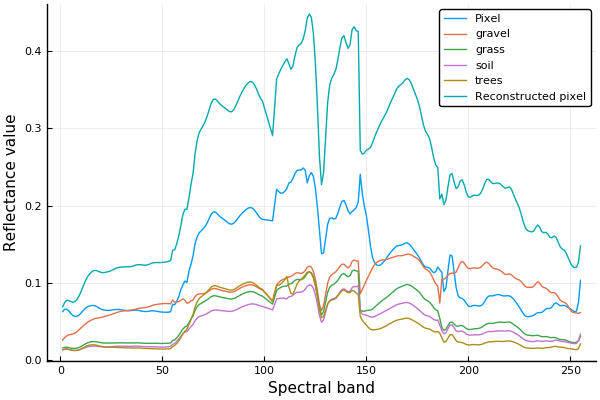

In [16]:
using Plots
pyplot()

plot(vect[1,10,:], label="Pixel")
plot!(A[10][1]*sources[:,1],label = "gravel")
plot!(A[10][2]*sources[:,2],label = "grass")
plot!(A[10][3]*sources[:,3],label = "soil")
plot!(A[10][4]*sources[:,4],label = "trees")
plot!(A[10][1]*sources[:,1] + A[10][2]*sources[:,2] + A[10][3]*sources[:,3] + A[10][4]*sources[:,4], label="Reconstructed pixel")
xlabel!("Spectral band")
ylabel!("Reflectance value")

In [17]:
rmprocs(2,3,4)
workers()

1-element Array{Int64,1}:
 1

In conclusion, a parallelized treatment is much longer than a serial treatment if we do the optimization pixel by pixel. We could not finish it on an image of more than 30x30 pixels with our machines. Let us try now a line by line treatment.
### Optimization for a whole line, serial and parallel, using projected gradient

#### Serial treatment

In [18]:
# if we consider a line of length q, l has size qx255
# A has size 4xq
p_line(l, A)  = 1/2*(l' - S*A)' * (l' - S*A) 
∇p_line(l, A) = -S'*l' + S'*S*A


function backtracking(l,a,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    while sum(p(l, a + t*d)) > sum(p(l, a)+α*t*transpose(∇p(l, a))*d)
        t=β*t
    end
    y = a+t*d
    return y
end

function proj_gradient(l)
    prec        = 1.e-8
    init        = 0.25*ones(4,size(l)[1])
    A             = init

    while true
        d= -∇p_line(l, A)
        A = backtracking(l, A, p_line, ∇p_line, d)
        # positivity constraint : we project on the constraint space
        for i=1:4
            for j=1:size(l)[1]
                if A[i,j] < 0
                A[i,j] = 0
                end
            end
        end
        if sum(-∇p_line(l, A)'*d/2) < prec 
            break
        end
    end
    return A
end

proj_gradient (generic function with 1 method)

In [19]:
img_small = img[101:200,101:200,:];
print("Optimal abundance : \n")

A = proj_gradient(img_small[15,:,:])

Optimal abundance : 


4×100 Array{Float64,2}:
 0.0927865  0.0903952  0.0894756  0.0896422  …  0.0980131  0.173929  0.205783
 0.166481   0.165233   0.164661   0.164712      0.17716    0.221769  0.238699
 0.184135   0.183148   0.182694   0.182735      0.192849   0.228012  0.241233
 0.18447    0.183681   0.183339   0.183508      0.200357   0.235336  0.246794

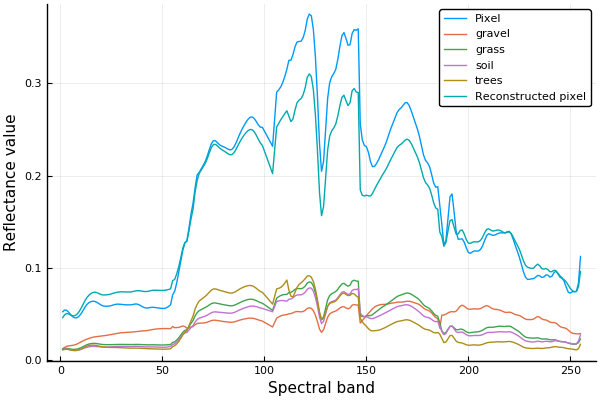

In [20]:
plot(img_small[15,9,:], label="Pixel")
plot!(A[1,9]*sources[:,1],label = "gravel")
plot!(A[2,9]*sources[:,2],label = "grass")
plot!(A[3,9]*sources[:,3],label = "soil")
plot!(A[4,9]*sources[:,4],label = "trees")
plot!(A[1,9]*sources[:,1] + A[2,9]*sources[:,2] + A[3,9]*sources[:,3] + A[4,9]*sources[:,4], label="Reconstructed pixel")
xlabel!("Spectral band")
ylabel!("Reflectance value")

Let us now try to optimize a whole sub-image of the of the original image, using a serial treatment, line by line :

In [21]:
#img_small = img[101:300,101:300,:];
img_small = img
t = @elapsed A = map(proj_gradient, [img_small[i,:,:] for i in range(1,stop=30)]);

2.904058799

In [ ]:
print("Time for a serial treatment of a sub-image, line by line : ", t, "sec")

#### Parallelized treatment

In [22]:
addprocs(CPU_CORES - 1)

@everywhere using MAT
@everywhere file = matopen("project_data.mat")
@everywhere img = read(file, "im")
@everywhere sources = read(file,"sources")
@everywhere rgb = read(file,"rgb")
@everywhere close(file)

In [23]:
workers()

3-element Array{Int64,1}:
 5
 6
 7

In [24]:
# if we consider a line of length q, l has size qx255
# A has size 4xq
@everywhere S= sources
@everywhere p_line(l, A)  = 1/2*(l' - S*A)' * (l' - S*A) 
@everywhere ∇p_line(l, A) = -S'*l' + S'*S*A


@everywhere function backtracking(l,a,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    while sum(p(l, a + t*d)) > sum(p(l, a)+α*t*transpose(∇p(l, a))*d)
        t=β*t
    end
    y = a+t*d
    return y
end

@everywhere function proj_gradient(l)
    prec        = 1.e-8
    init        = 0.25*ones(4,size(l)[1])
    A             = init

    while true
        d= -∇p_line(l, A)
        A = backtracking(l, A, p_line, ∇p_line, d)
        # positivity constraint : we project on the constraint space
        for i=1:4
            for j=1:size(l)[1]
                if A[i,j] < 0
                A[i,j] = 0
                end
            end
        end
        if sum(-∇p_line(l, A)'*d/2) < prec 
            break
        end
    end
    return A
end

In [25]:
#img_small = img[101:300,101:300,:];
img_small = img
t = @elapsed A = pmap(proj_gradient, [img_small[i,:,:] for i in range(1,stop=size(img_small)[1])]);

15.028374801

In [ ]:
print("Time for a parallelized treatment of a sub-image, line by line : ", t, "sec")

A parallelized, line by line treatment works better than a parallelized pixel by pixel treatment (here we were able to perform the optimization on the whole sub-image). However, the parallelized treatment remains slower than a serial treatment, with an execution time of 15 seconds against 3 seconds for the serial treatment.

In [26]:
rmprocs(5,6,7)
workers()

1-element Array{Int64,1}:
 1

### Pixel by pixel optimization using linearly constrained Newton and the log-barrier method to modelize the inequality constraint

#### Serial treatment

We realized that the backtracking function rarely performed more than 1 iteration here, so we decided not to use it in the following.

In [41]:
S= sources

p(px, x,y,u,v)  = 1/2*(px - S*[x;y;u;v])' * (px - S*[x;y;u;v]) 
∇p(px, x,y,u,v) = -[S[:,1]';S[:,2]';S[:,3]';S[:,4]']*px + S'*S*[x;y;u;v]
∇2p(x,y,u,v) = S'*S

h(x,y,u,v)  = x+y+u+v - 1
∇h      = [1,1,1,1]

gx(x,y,u,v)=-x
gy(x,y,u,v)=-y
gu(x,y,u,v)=-u
gv(x,y,u,v)=-v

"""∇gx(x,y,u,v)=[-1;0;0;0]
∇gy(x,y,u,v)=[0;-1;0;0]
∇gu(x,y,u,v)=[0;0;-1;0]
∇gv(x,y,u,v)=[0;0;0;-1]"""

ϕx(x,y,u,v) = -log(-gx(x,y,u,v))
ϕy(x,y,u,v) = -log(-gy(x,y,u,v))
ϕu(x,y,u,v) = -log(-gu(x,y,u,v))
ϕv(x,y,u,v) = -log(-gv(x,y,u,v))

p2(px, x,y,u,v)= p(px,x,y,u,v) + ϕx(x,y,u,v) + ϕy(x,y,u,v) + ϕu(x,y,u,v) +ϕv(x,y,u,v)
∇p2(px, x,y,u,v) =  ∇p(px,x,y,u,v) + [-1/x; -1/y; -1/u; -1/v]
∇2p2(x,y,u,v) =  ∇2p(x,y,u,v) + [1/(x*x) 0 0 0 ;
                                    0 1/(y*y) 0 0; 
                                    0 0 1/(u*u) 0;
                                    0 0 0 1/(v*v)]

function backtracking(px,x,p,∇p,d)
    """
    bactracking: 
    IN:
    ---
    x: initial point
    p, ∇p: function to be minimized and its gradient
    d: search direction
    OUT:
    ----
    y: final point
    n: number of loops
    """
    α,β = 0.25, 0.7 # backtracking parameters
    t = 1
    n=0
    while p(px, x[1]+t*d[1],x[2]+t*d[2],x[3]+t*d[3], x[4]+t*d[4] ) > p(px, x[1],x[2],x[3],x[4])+α*t*transpose(∇p(px, x[1],x[2],x[3],x[4]))*d
        t=β*t
        n+=1
    end
    y = x+t*d
    return y,n
end

function newton(px)
    prec        = 1.e-8
    init        = [0.25; 0.25; 0.25; 0.25]
    pt          = init
    nb_iter_N   = 0  # number of loops
    nb_loops_N  = 0  # number of inner loops count for backtracking
    
    # print(size(∇p(px, pt[1],pt[2],pt[3],pt[4])))
    # print(size([-1/pt[1]; -1/pt[2]; -1/pt[3]; -1/pt[4]]))

    b=1
    while true
        M = [∇2p2(pt[1],pt[2],pt[3],pt[4]) ∇h;
            transpose(∇h) 0]
        B = [-∇p2(px, pt[1],pt[2],pt[3],pt[4]); 
            b.-transpose(∇h)*pt]
        H = inv(M)*B # MH=B
        λ = H[5]
        h_vect = [H[1], H[2], H[3], H[4]] # search direction
        #pt, n = backtracking(px, pt, p2, ∇p2, h_vect)
        pt, n = pt + 0.1*h_vect, 0
        nb_loops_N +=n
        d=h_vect
        if (-∇p2(px, pt[1],pt[2],pt[3],pt[4])'*d/2) < prec  # ∇f(x+td)_{t=0}= ∇'*d
            break
        end
        nb_iter_N += 1
    end
    return pt
end

newton (generic function with 1 method)

In [29]:
img_small = img[101:130,101:130,:];
vect = reshape(img_small,(1,900,255))
t = @elapsed A = map(newton, [vect[1,i,:] for i in range(1,stop=900)]);

4.611931701

In [ ]:
print("Time for a serial treatment of a 30x30 px sub-image, pixel by pixel : ", t, "sec")

Performing the serial optimization on a 30x30 px sub-image takes about 5 seconds.
Below, we assess the positivity constraint : variable $b$ equals "true" if this constraint is complied with.

In [4]:
b = true
for i=1:900
    for j=1:4
        if A[i][j] < 0
            b = false
        end
    end
end
b

true

N.B. : by using the log-barrier method, we forbid null coefficients. Any coefficient corresponding to an endmember will thus be strictly positive.
Below, we assess the equality constraint :

In [5]:
for i=1:900
    print(sum(A[i]),"\n")
end

1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999998
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
0.9999999999999999
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
0.9999999999999998
1.0
0.9999999999999999
1.0000000000000002
0.9999999999999999
1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
0.9999999999999998
1.0
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999

Below, we reconstructed the reflectance corresponding to pixel n° 10, using the sources and the optimal coefficients we previously found.

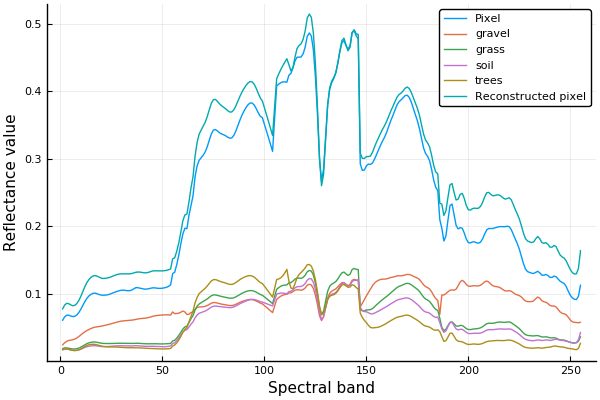

In [6]:
using Plots
pyplot()

plot(vect[1,10,:], label="Pixel")
plot!(A[10][1]*sources[:,1],label = "gravel")
plot!(A[10][2]*sources[:,2],label = "grass")
plot!(A[10][3]*sources[:,3],label = "soil")
plot!(A[10][4]*sources[:,4],label = "trees")
plot!(A[10][1]*sources[:,1] + A[10][2]*sources[:,2] + A[10][3]*sources[:,3] + A[10][4]*sources[:,4], label="Reconstructed pixel")
xlabel!("Spectral band")
ylabel!("Reflectance value")

In [32]:
img_small = img[101:200,101:200,:];
vect = reshape(img_small,(1,10000,255))
t = @elapsed A = map(newton, [vect[1,i,:] for i in range(1,stop=10000)])

48.344938899

In [ ]:
print("Time for a serial treatment of a 100x100 sub-image, pixel by pixel : ", t, "sec")

In [34]:
img_small = img
vect = reshape(img_small,(1,90000,255))
t = @elapsed A = map(newton, [vect[1,i,:] for i in range(1,stop=90000)])

432.282574701

In [ ]:
print("Time for a serial treatment of the whole image, pixel by pixel : ", t, "sec")

### Parallelized treatment :

In [7]:
# using Distributed

In [14]:
addprocs(3)

3-element Array{Int64,1}:
 5
 6
 7

In [15]:
@everywhere using MAT
@everywhere file = matopen("project_data.mat")
@everywhere img = read(file, "im")
@everywhere sources = read(file,"sources")
@everywhere rgb = read(file,"rgb")
@everywhere close(file)

In [27]:
@everywhere S= sources

@everywhere p(px, x,y,u,v)  = 1/2*(px - S*[x;y;u;v])' * (px - S*[x;y;u;v]) 
@everywhere ∇p(px, x,y,u,v) = -[S[:,1]';S[:,2]';S[:,3]';S[:,4]']*px + S'*S*[x;y;u;v]
@everywhere ∇2p(x,y,u,v) = S'*S

@everywhere h(x,y,u,v)  = x+y+u+v - 1
@everywhere ∇h      = [1,1,1,1]

@everywhere gx(x,y,u,v)=-x
@everywhere gy(x,y,u,v)=-y
@everywhere gu(x,y,u,v)=-u
@everywhere gv(x,y,u,v)=-v

@everywhere ϕx(x,y,u,v) = -log(-gx(x,y,u,v))
@everywhere ϕy(x,y,u,v) = -log(-gy(x,y,u,v))
@everywhere ϕu(x,y,u,v) = -log(-gu(x,y,u,v))
@everywhere ϕv(x,y,u,v) = -log(-gv(x,y,u,v))

@everywhere p2(px, x,y,u,v)= p(px,x,y,u,v) + ϕx(x,y,u,v) + ϕy(x,y,u,v) + ϕu(x,y,u,v) + ϕv(x,y,u,v)
@everywhere ∇p2(px, x,y,u,v) =  ∇p(px,x,y,u,v) + [-1/x; -1/y; -1/u; -1/v]
@everywhere ∇2p2(x,y,u,v) =  ∇2p(x,y,u,v) + [1/(x*x) 0 0 0 ;
                                    0 1/(y*y) 0 0; 
                                    0 0 1/(u*u) 0;
                                    0 0 0 1/(v*v)]


@everywhere function newton(px)
    prec        = 1.e-8
    init        = [0.25; 0.25; 0.25; 0.25]
    pt          = init
    nb_iter_N   = 0  # number of loops
    nb_loops_N  = 0  # number of inner loops count for backtracking
    
    # print(size(∇p(px, pt[1],pt[2],pt[3],pt[4])))
    # print(size([-1/pt[1]; -1/pt[2]; -1/pt[3]; -1/pt[4]]))

    b=1
    while true
        M = [∇2p2(pt[1],pt[2],pt[3],pt[4]) ∇h;
            transpose(∇h) 0]
        B = [-∇p2(px, pt[1],pt[2],pt[3],pt[4]); 
            b.-transpose(∇h)*pt]
        H = inv(M)*B # MH=B
        λ = H[5]
        h_vect = [H[1], H[2], H[3], H[4]] # search direction
        pt, n = pt + 0.1*h_vect, 0
        nb_loops_N +=n
        d=h_vect
        if (-∇p2(px, pt[1],pt[2],pt[3],pt[4])'*d/2) < prec  # ∇f(x+td)_{t=0}= ∇'*d
            break
        end
        nb_iter_N += 1
    end
    return pt
end

In [28]:
img_small = img[101:130,101:130,:];
vect = reshape(img_small,(1,900,255))
t = @elapsed A = pmap(newton, [vect[1,i,:] for i in range(1,stop=900)])

6.4687585

In [ ]:
print("Time for a parallelized treatment of a 30x30 px sub-image, pixel by pixel : ", t, "sec")

This takes about 2 seconds more than the same serial treatment.

In [33]:
img_small = img[101:200,101:200,:];
vect = reshape(img_small,(1,10000,255))
t = @elapsed A = pmap(newton, [vect[1,i,:] for i in range(1,stop=10000)])

22.632022301

The parallelized treatment on a 100x100 px sub-image takes 22 seconds, against 48 for the serial treatment.

In [35]:
img_small = img
vect = reshape(img_small,(1,90000,255))
t = @elapsed A = pmap(newton, [vect[1,i,:] for i in range(1,stop=90000)])

153.873864101

The parallelized treatment on the whole image takes 2 minutes and 30 seconds, against 7 minutes for the serial treatment.